In [1]:
# Styling notebook
from IPython.core.display import display, HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

C:\Users\Renata\AppData\Local\Temp\ipykernel_1916\1617930524.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Inicio

## Importação de libs

In [2]:
# para ler arquivo excel (xls)
# conda install -c anaconda xlrd

import datetime
from datetime import datetime
import os

# Analise
import pandas as pd 
import numpy as np 

#Visualization
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import plotly
import plotly.express as px

## Configurações

In [3]:
# para habilitar rolagem horizontal do dataframe 
# caso não funcione no Firefox
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

In [4]:
# formatação de mensagens de print
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
#print(color.BOLD + 'Hello World !' + color.END)

## Parâmetros

In [5]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
pd.set_option('max_colwidth', 1000) # tamanho das colunas para exibição do conteúdo de textos longos

np.set_printoptions(threshold=1000)

# Formatar numeros float (2 casas decimais)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

# Formatações para gráficos
sns.set(style="darkgrid") #cor da area dos plots
figsize = (10,10)

## Links uteis

- Cores em graficos plotly: https://plotly.com/python/discrete-color/
- https://www.selecolor.com/en/recommended-color-palette/

# Definição de funções

## checar_df

Para um determinado dataframe, são verificados:

- total de registros;
- quantidade e tipos de colunas;
- quantidade de valores únicos;
- quantidade de valores nulos (para identificar a necessidade de pre processamento dos dados).

In [6]:
def checar_df(df):
    print(color.BOLD  + color.RED + 'Informações do dataframe: ' + color.END)
    df.info()
    
    print(color.BOLD + color.RED + "\nNúmero de observacoes na base de dados: " + color.END, df.shape[0])
    print('Total de ', df.shape[1], 'Colunas: ', df.columns.values.tolist())
    
    print(color.BOLD + color.RED + "\nNúmero de valores unicos (Não inclui NaN): " + color.END)
    display(df.nunique(dropna=True).to_frame(name='Contagem Unicos').sort_index())
    
    print(color.BOLD + color.RED + "Número de valores nulos:" + color.END)
    display(df.isnull().sum().sort_values(ascending=False).to_frame(name='Contagem Nulos').sort_index())

## Gerar Plot de Evolução por Ano

In [7]:
def gerar_plot_evol_ano(df, col_ano, col_grupo, col_soma, legenda_outside):

    # exibe primeiros registros do df
    print('Exibindo alguns registros do df consolidado...\n')
    df_plot = df.groupby([col_ano, col_grupo])[col_soma].sum().reset_index().rename(columns={col_soma:'Total'})
    display(df_plot.head(5))
    
    ano_min = df_plot[col_ano].min()
    ano_max = df_plot[col_ano].max()
    
    print(f'Soma da coluna {col_soma} nos anos de {ano_min} a {ano_max}: {df[col_soma].sum()}')

    f, axes = plt.subplots(1, 1,  figsize=(20,8))

    # controle dos valores do eixo Y 
    data = df_plot.copy()
    y_max = df_plot['Total'].max()
    if y_max >= 10000: 
        data['Total'] = data['Total']/1000
        limite_sup = y_max/1000 * 1.10
        intervalo = round((limite_sup/10)/100)*100
        if intervalo==0: intervalo = limite_sup/10
        text_y_axis = 'Total (x 1000)'
        
    else:  
        limite_sup = y_max * 1.10
        intervalo = limite_sup / 10
        text_y_axis = 'Total'
        
    #limite_sup = df_plot['Total'].max()/1000 * 1.10
    
    sns.pointplot(x=col_ano, y='Total', hue=col_grupo, 
                data=data.sort_values(by=([col_ano,'Total']), ascending=[False,False]), ax=axes,
                 markers='o')
    
    axes.set_title(f'Evolução {col_soma} - PRESENCIAL por Ano', fontsize=20)
    axes.set_xticklabels(axes.get_xticklabels(), rotation=0, ha="right", fontsize=16)
    axes.set(xlabel=''); axes.set_ylabel(text_y_axis, fontsize=18)
    
    major_yticks = np.arange(0, limite_sup, intervalo); 
    axes.set_yticks(major_yticks)
    axes.tick_params(axis='y', labelsize=14)
    axes.grid(color='gray', linestyle='--', linewidth=1.2, axis='both', alpha=.2)

    axes.legend(loc='best', fontsize=18)
    if legenda_outside == 'S':
        axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, 
                    ncol=2, fontsize='large')
    plt.show()

# Carga dos Dados 

## Dados IBGE

In [8]:
# definir os tipos de algumas colunas
# para facilitar operações de merge
list_col_string = ['COD_IBGE', 'CAPITAL','Cod_Mesorregiao','Cod_Microrregiao'] 
dict_dtype = {column : 'str'  for column in list_col_string}

ibge = pd.read_csv('./dados/preparados/dados_ibge_consolidado.csv', sep='|', 
                   dtype = dict_dtype, 
                   low_memory=False)

# renomear colunas para nomes mais intuitivos
ibge = ibge.rename(columns={'POP_IBGE_2013':'POP_2013',
                            'POP_IBGE_2022':'POP_2022'})

ibge.info()
ibge.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   REGIAO             5570 non-null   object 
 1   NOME_REGIAO        5570 non-null   object 
 2   SIGLA_UF           5570 non-null   object 
 3   NOME_UF            5570 non-null   object 
 4   COD_IBGE           5570 non-null   object 
 5   NOME_MUNICIPIO     5570 non-null   object 
 6   LAT                5570 non-null   float64
 7   LNG                5570 non-null   float64
 8   POP_2013           5570 non-null   int64  
 9   CAPITAL            5570 non-null   object 
 10  POP_2022           5570 non-null   int64  
 11  Cod_Mesorregiao    5570 non-null   object 
 12  Nome_Mesorregiao   5570 non-null   object 
 13  Cod_Microrregiao   5570 non-null   object 
 14  Nome_Microrregiao  5570 non-null   object 
dtypes: float64(2), int64(2), object(11)
memory usage: 652.9+ KB


REGIAO NOME_REGIAO SIGLA_UF   NOME_UF COD_IBGE         NOME_MUNICIPIO  \
0      N       Norte       RO  Rondônia  1100015  Alta Floresta D'Oeste   
1      N       Norte       RO  Rondônia  1100023              Ariquemes   
2      N       Norte       RO  Rondônia  1100031                 Cabixi   
3      N       Norte       RO  Rondônia  1100049                 Cacoal   
4      N       Norte       RO  Rondônia  1100056             Cerejeiras   

     LAT    LNG  POP_2013 CAPITAL  POP_2022 Cod_Mesorregiao  \
0 -11.94 -62.00     25728       0     21558              02   
1  -9.91 -63.03    101269       0    100896              02   
2 -13.50 -60.54      6495       0      5107              02   
3 -11.43 -61.44     85863       0     92202              02   
4 -13.20 -60.82     18041       0     15237              02   

    Nome_Mesorregiao Cod_Microrregiao  Nome_Microrregiao  
0  Leste Rondoniense              006             Cacoal  
1  Leste Rondoniense              003          Ariquemes  
2  Leste Rondoniense              008  Colorado do Oeste  
3  Leste Rondoniense              006             Cacoal  
4  Leste Rondoniense              008  Colorado do Oeste

## Dados Matriculas 2012 a 2022

In [9]:
# selecionar todas colunas que começam com CO_ e outras (transformar em string) 
#colunas_CO = [col for col in cursos if col.startswith('CO_')] + ['IN_CAPITAL', 'IN_GRATUITO']
colunas_CO = ['CO_REGIAO', 'CO_UF', 'CO_MUNICIPIO', 'CO_IES', 'CO_CURSO', 'CO_CINE_ROTULO', 'CO_CINE_AREA_GERAL',
 'CO_CINE_AREA_ESPECIFICA', 'CO_CINE_AREA_DETALHADA', 'IN_CAPITAL', 'IN_GRATUITO']

col_int = ['NU_ANO_CENSO', 'NO_CINE_AREA_GERAL','Tipo_Rede','QT_MAT',
          'QT_MAT_FEM', 'QT_MAT_MASC', 'QT_MAT_DIURNO', 'QT_MAT_NOTURNO',
       'QT_MAT_0_17', 'QT_MAT_18_24', 'QT_MAT_25_29', 'QT_MAT_30_34',
       'QT_MAT_35_39', 'QT_MAT_40_49', 'QT_MAT_50_59', 'QT_MAT_60_MAIS',
       'QT_MAT_BRANCA', 'QT_MAT_PRETA', 'QT_MAT_PARDA', 'QT_MAT_AMARELA',
       'QT_MAT_INDIGENA', 'QT_MAT_CORND']

In [10]:
# # %%time
# dict_dtype = {column : 'str'  for column in colunas_CO}
# cursos_2013 = pd.read_csv('./dados/preparados/dados_cursos_escopo_consolidado_2013.csv', sep='|', 
#                    dtype = dict_dtype, 
#                    low_memory=False)
# cursos_2013.shape

In [11]:
%%time

# prepara lista de csvs 2012 a 2022
lista_csvs = [ f'dados_cursos_escopo_consolidado_{i}.csv' for i in range(2012,2023,1)]

dict_dtype = {column : 'str'  for column in colunas_CO}
df_all = pd.concat((
    pd.read_csv(f'./dados/preparados/{file}', sep='|', 
                          dtype = dict_dtype, 
                          low_memory=False
                          #usecols=col_int
               )
    for file in lista_csvs))

CPU times: total: 9.48 s
Wall time: 9.56 s


In [12]:
# Verifica contagem de registros de cursos em cada ano
df_all['NU_ANO_CENSO'].value_counts().sort_index()

NU_ANO_CENSO
2012    25682
2013    25674
2014    26251
2015    27344
2016    28208
2017    29034
2018    30620
2019    31544
2020    31382
2021    31203
2022    31309
Name: count, dtype: int64

In [13]:
# salvar em arquivo
#df_all.to_csv('./dados/preparados/dados_cursos_2012_2022.csv', sep='|', index=False)

# Tratamentos

## Correção de dados do ano de 2013

Todos os registros com o campo TP_REDE = nan
Desta forma, será feita atualização deste campo em função do campo TP_CATEGORIA_ADMINISTRATIVA (Tipo_Cat_Admn)

In [14]:
display(df_all[df_all['NU_ANO_CENSO']==2013]['TP_REDE'].value_counts())
df_all[df_all['NU_ANO_CENSO']==2013]['Tipo_Cat_Admn'].value_counts()

Series([], Name: count, dtype: int64)

Tipo_Cat_Admn
Privada sem fins lucrativos    11130
Privada com fins lucrativos     9049
Pública Federal                 5495
Name: count, dtype: int64

In [15]:
#cursos_2013[cursos_2013['NU_ANO_CENSO']==2013]['Tipo_Cat_Admn'].value_counts()

In [16]:
df_all['TIPO_INST'] = np.where(df_all['Tipo_Cat_Admn'].str.contains('Pública'),'Pública','Privada')

In [17]:
df_all['Tipo_Cat_Admn'].value_counts()

Tipo_Cat_Admn
Privada com fins lucrativos    133550
Privada sem fins lucrativos    118184
Pública Federal                 66517
Name: count, dtype: int64

In [18]:
df_all['TIPO_INST'].value_counts()

TIPO_INST
Privada    251734
Pública     66517
Name: count, dtype: int64

# Graficos Matrículas

## Evolução Total Matriculas por Ano/ Tipo Rede

In [19]:
#df_all.groupby(['NU_ANO_CENSO', 'Tipo_Rede'])['QT_MAT'].sum() # problema com 2013
serie_matr = df_all.groupby(['NU_ANO_CENSO', 'TIPO_INST'])['QT_MAT'].sum().reset_index().rename(columns={'QT_MAT':'Total_matriculas'})
serie_matr.head()

NU_ANO_CENSO TIPO_INST  Total_matriculas
0          2012   Privada        4207735.00
1          2012   Pública         976471.00
2          2013   Privada        4373835.00
3          2013   Pública        1033732.00
4          2014   Privada        4664239.00

Total de matriculas nos anos de 2012 a 2022:  59098306.0


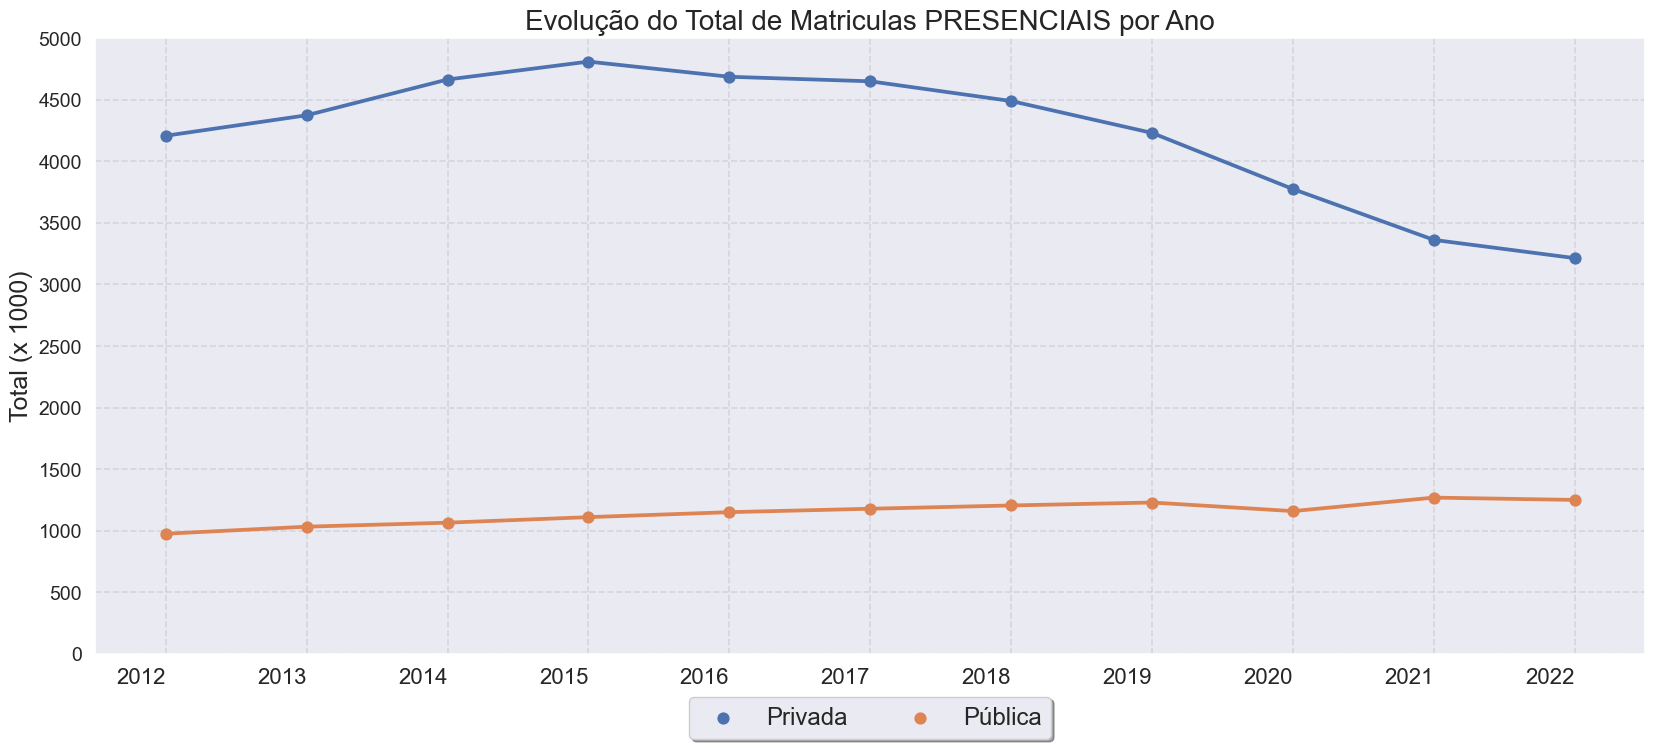

In [20]:
ano_min = serie_matr['NU_ANO_CENSO'].min()
ano_max = serie_matr['NU_ANO_CENSO'].max()
print('Total de matriculas nos anos de %s a %s: ' % (ano_min, ano_max ), serie_matr['Total_matriculas'].sum())

f, axes = plt.subplots(1, 1,  figsize=(20,8))

data = serie_matr.copy()
data['Total_matriculas'] = data['Total_matriculas']/1000

axes = sns.pointplot(x='NU_ANO_CENSO', y='Total_matriculas', hue='TIPO_INST', 
            data=data.sort_values(by=(['NU_ANO_CENSO','Total_matriculas']), ascending=[False,False]), 
             markers='o')

axes.set_title("Evolução do Total de Matriculas PRESENCIAIS por Ano", fontsize=20)
axes.set_xticklabels(axes.get_xticklabels(), rotation=0, ha="right", fontsize=16)
axes.set(xlabel=''); axes.set_ylabel('Total (x 1000)', fontsize=18)

limite_sup = serie_matr['Total_matriculas'].max()/1000 * 1.10
intervalo = round((limite_sup/10)/100)*100
major_yticks = np.arange(0, limite_sup, intervalo); 
axes.set_yticks(major_yticks)
axes.tick_params(axis='y', labelsize=14)

axes.grid(color='gray', linestyle='--', linewidth=1.2, axis='both', alpha=.2)

#axes.legend(loc='best', fontsize=18)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3,
           fontsize='x-large')
plt.show()

## Evolução Total Matriculas por Ano / Grau Academico

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO Tipo_Grau_Acad      Total
0          2012    Bacharelado 3940215.00
1          2012   Licenciatura  671569.00
2          2012    Tecnológico  572422.00
3          2013    Bacharelado 4142248.00
4          2013   Licenciatura  683852.00

Soma da coluna QT_MAT nos anos de 2012 a 2022: 59098306.0


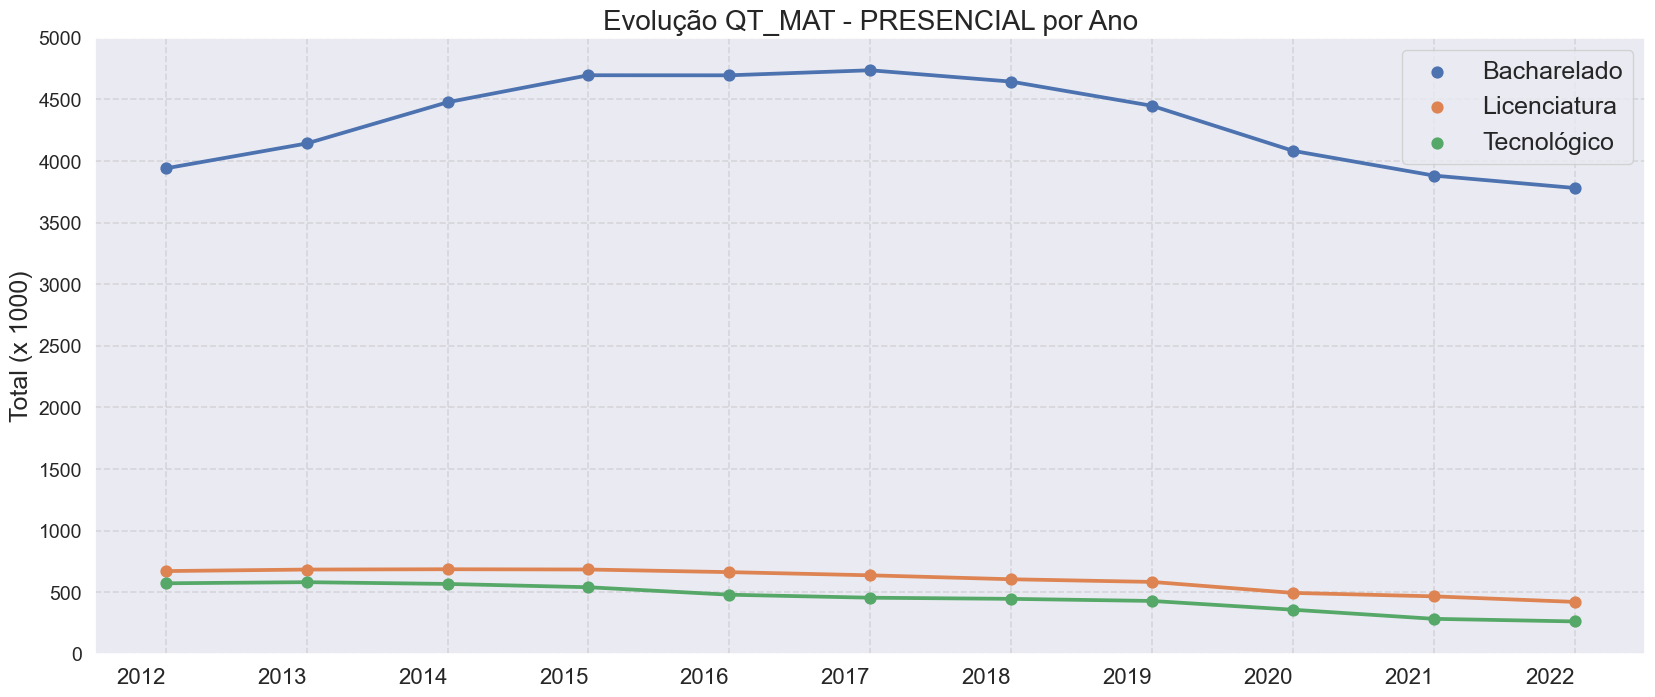

In [21]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Tipo_Grau_Acad'
col_soma = 'QT_MAT'
legenda_outside = 'N'

gerar_plot_evol_ano(df_all, col_ano, col_grupo, col_soma, legenda_outside)

## Evolução Total Matriculas por Ano / Area Curso

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO                                          NO_CINE_AREA_GERAL  \
0          2012              Agricultura, silvicultura, pesca e veterinária   
1          2012                                         Artes e humanidades   
2          2012                 Ciências naturais, matemática e estatística   
3          2012                  Ciências sociais, comunicação e informação   
4          2012  Computação e Tecnologias da Informação e Comunicação (TIC)   

      Total  
0 130065.00  
1 134190.00  
2  92645.00  
3 300425.00  
4 238926.00

Soma da coluna QT_MAT nos anos de 2012 a 2022: 59097487.0


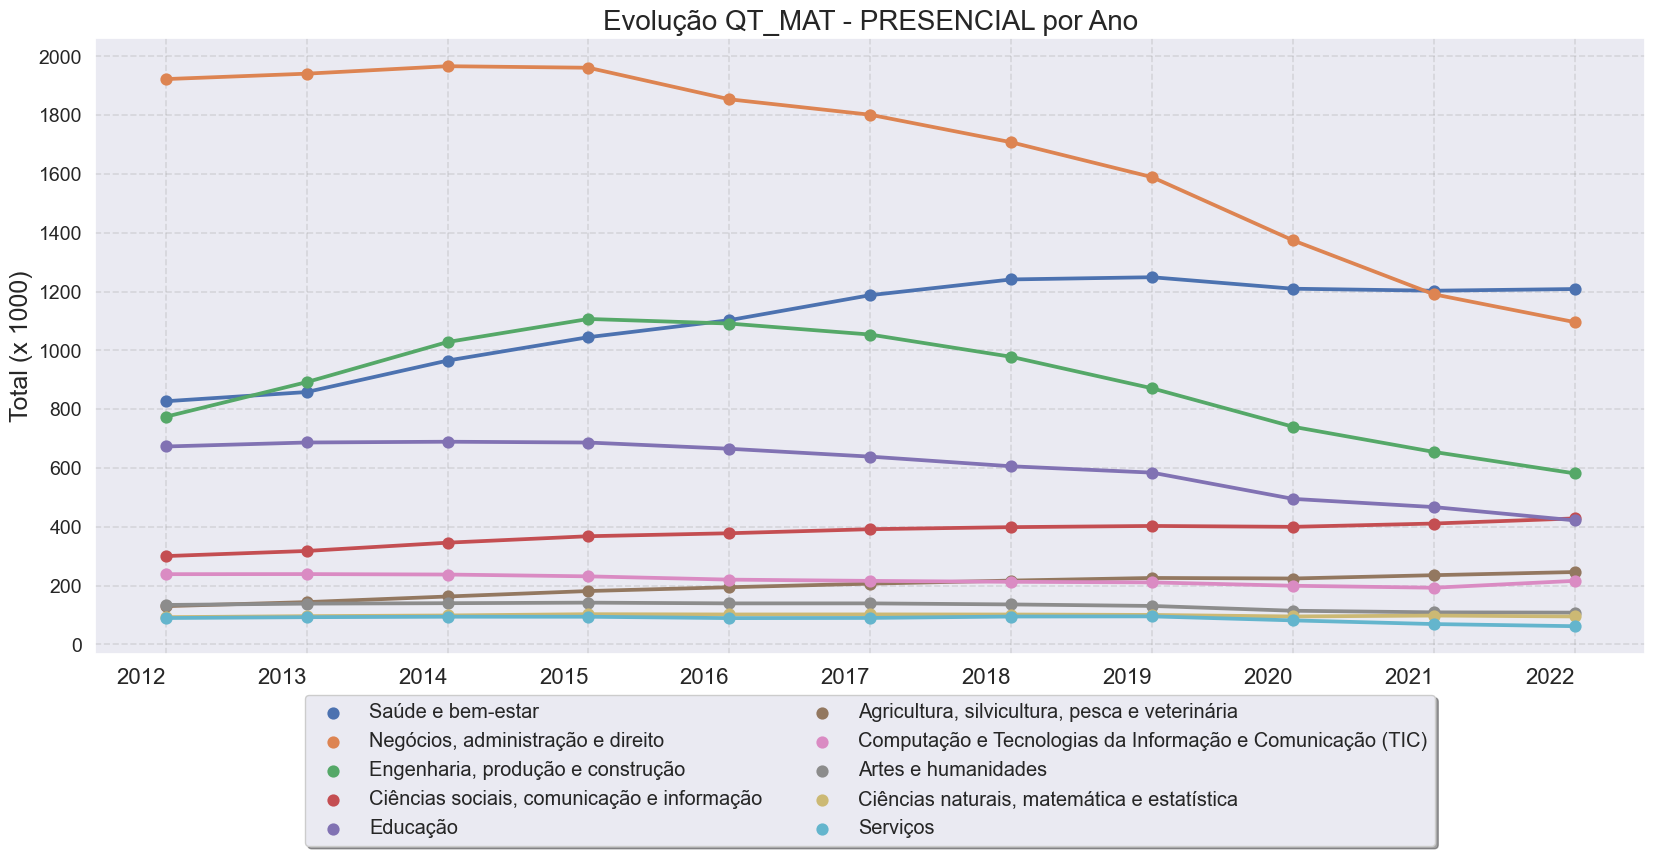

In [22]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'NO_CINE_AREA_GERAL'
col_soma = 'QT_MAT'
legenda_outside = 'S'

# retirar area especifica: Programas básicos
#df_all['NO_CINE_AREA_GERAL'].value_counts()
df_areas = df_all[~df_all['NO_CINE_AREA_GERAL'].isin(['Programas básicos'])]

gerar_plot_evol_ano(df_areas, col_ano, col_grupo, col_soma, legenda_outside)

## Evolução Total Matriculas por Ano / Idade

### Preparação dos dados

In [23]:
serie_matr_faixas_t1 = df_all.melt(id_vars=['NU_ANO_CENSO','CO_IES','NO_CURSO','QT_MAT'], var_name='Faixa_etaria', 
                                   value_name = 'Total_MAT',
                                   value_vars=['QT_MAT_0_17', 'QT_MAT_18_24', 'QT_MAT_25_29', 'QT_MAT_30_34',
                                               'QT_MAT_35_39', 'QT_MAT_40_49', 'QT_MAT_50_59', 'QT_MAT_60_MAIS'])
#display(serie_matr_faixas_t1.head(5))
serie_matr_faixas_t2 = serie_matr_faixas_t1.groupby(['NU_ANO_CENSO', 'CO_IES','NO_CURSO','QT_MAT','Faixa_etaria'])['Total_MAT']\
                                            .sum().reset_index()
#display(serie_matr_faixas_t2.head(5))

### Checar um exemplo

In [24]:
# para checar um exemplo: um curso de uma universidade em um ano 
# se os calculos de soma de idades batem
# display(df_all[(df_all['CO_IES']=='1497') & (df_all['NU_ANO_CENSO']==2012)][col])

# display(serie_matr_faixas_t2[
# (serie_matr_faixas_t2['CO_IES']=='1497')
#         & (serie_matr_faixas_t2['NU_ANO_CENSO']==2012)
#         & (serie_matr_faixas_t2['NO_CURSO']=='ADMINISTRAÇÃO')])

### Gráfico

In [25]:
serie_matr_faixas = serie_matr_faixas_t2.groupby(['NU_ANO_CENSO','Faixa_etaria'])['Total_MAT'].sum().reset_index()

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO  Faixa_etaria      Total
0          2012   QT_MAT_0_17   21789.00
1          2012  QT_MAT_18_24 2890236.00
2          2012  QT_MAT_25_29 1068217.00
3          2012  QT_MAT_30_34  566482.00
4          2012  QT_MAT_35_39  293387.00

Soma da coluna Total_MAT nos anos de 2012 a 2022: 59098306.0


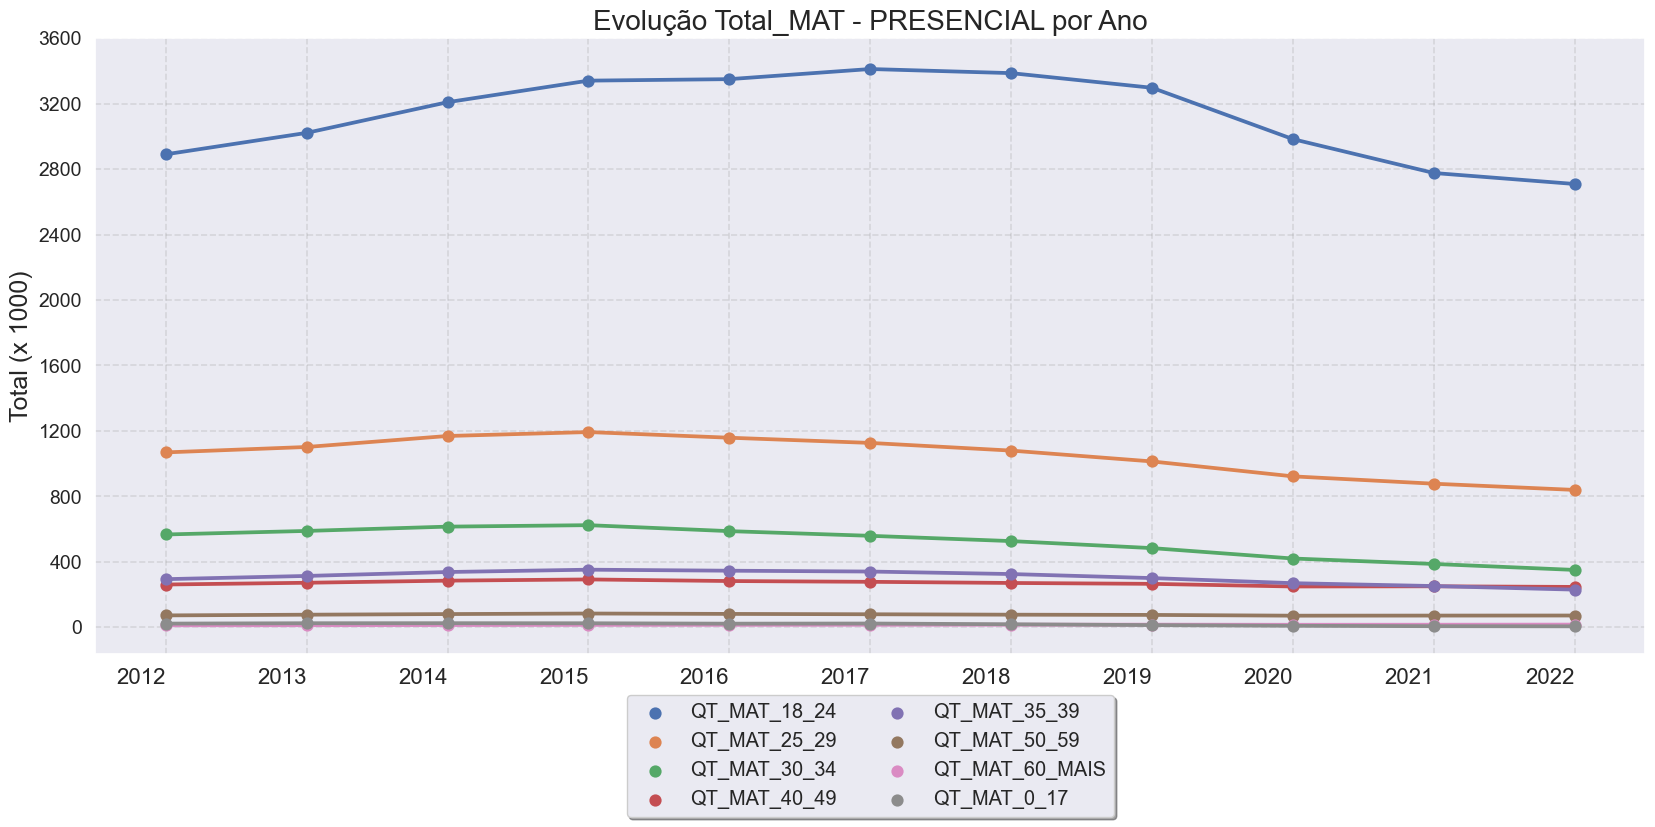

In [26]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Faixa_etaria'
col_soma = 'Total_MAT'
legenda_outside = 'S'

gerar_plot_evol_ano(serie_matr_faixas, col_ano, col_grupo, col_soma, legenda_outside)

## Evolução Total Matriculas por Ano / UF / Rede Ensino

In [27]:
# col = ['NU_ANO_CENSO', 'SG_UF','TIPO_INST','QT_MAT']
# evol_matr_uf_rede = df_all.groupby(['NU_ANO_CENSO', 'SG_UF','TIPO_INST'])['QT_MAT'].sum()\
#                     .reset_index().rename(columns={'QT_MAT':'Total_Mat'})
# evol_matr_uf_rede.head()

In [28]:
# Total Matr por Ano e UF 
tot_matr_uf = df_all.groupby(['NU_ANO_CENSO', 'SG_UF'])['QT_MAT'].sum()

# Total e Perc Matr por Ano, UF, Rede de Ensino 
tot_matr_uf_re = df_all.groupby(['NU_ANO_CENSO', 'SG_UF', 'TIPO_INST'])['QT_MAT'].sum()
perc_matr_uf_re = round((tot_matr_uf_re / tot_matr_uf*100),2)

# consolidar em dataframe
distr_matr_uf_re = pd.DataFrame({'Total_Mat'  : tot_matr_uf_re,
                                 'Total_Mat_p': perc_matr_uf_re}).reset_index()

distr_matr_uf_re['Total_Mat_mil'] = distr_matr_uf_re['Total_Mat']/1000
distr_matr_uf_re.head()

NU_ANO_CENSO SG_UF TIPO_INST  Total_Mat  Total_Mat_p  Total_Mat_mil
0          2012    AC   Privada   10444.00        47.82          10.44
1          2012    AC   Pública   11397.00        52.18          11.40
2          2012    AL   Privada   38576.00        58.40          38.58
3          2012    AL   Pública   27477.00        41.60          27.48
4          2012    AM   Privada   78813.00        74.00          78.81

In [30]:
# para determinar max do eixo y
#distr_matr_uf_re['Total_Mat_mil'].max()
#distr_matr_uf_re['Total_Mat_mil'].min()

In [31]:
# Total de ingressantes por Ano e por UF
tot_ing_uf = df_all.groupby(['NU_ANO_CENSO', 'SG_UF'])['QT_ING'].sum().reset_index().rename(columns={'QT_ING':'Total_Ingr'})
tot_ing_uf['Total_Ingr_mil'] = tot_ing_uf['Total_Ingr'] / 1000
tot_ing_uf.head()

NU_ANO_CENSO SG_UF  Total_Ingr  Total_Ingr_mil
0          2012    AC     7662.00            7.66
1          2012    AL    20605.00           20.61
2          2012    AM    41105.00           41.10
3          2012    AP     8457.00            8.46
4          2012    BA    85294.00           85.29

In [32]:
# Checar plot para um ano
# f, axes = plt.subplots(1, 1,  figsize=(16, 8))
# cores = sns.color_palette("terrain")

# ano = 2012
# data = distr_matr_uf_re[distr_matr_uf_re['NU_ANO_CENSO']==ano].sort_values(by='SG_UF', ascending=True)
# g = sns.barplot(x='SG_UF', 
#                 y='Total_Mat_mil', hue='TIPO_INST', 
#                 data=data, orient='v',
#                 ax=axes, palette = cores)
# titulo = 'Total de Matrículas por UF - ' + str(ano)
# axes.set_title(titulo, fontsize=18)

# major_yticks = np.arange(0, 1600, 200)
# axes.set_yticks(major_yticks)
# axes.set(xlabel=''); axes.set(ylabel='')
# axes.legend(loc='upper center', fontsize=18).set_visible(False)
# axes.grid(visible=False)

# ax2 = axes.twinx()
# dados2 = tot_ing_uf[tot_ing_uf['NU_ANO_CENSO']==2012].sort_values(by='SG_UF', ascending=True)
# ax2.plot(dados2['SG_UF'], 
#          dados2['Total_Ingr_mil'],
#         color='#ff3333', label='Total_Ingr_mil')
# ax2.set_ylabel("Total Ingressantes")
# ax2.set_yticks(major_yticks)
# ax2.grid(visible=True, linestyle = "dashed", color='white')

# lines1, labels1 = axes.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper center", fontsize=18)

# plt.show()

Total de Matrículas por UF e Rede de Ensino - Anos 2012 a 2022


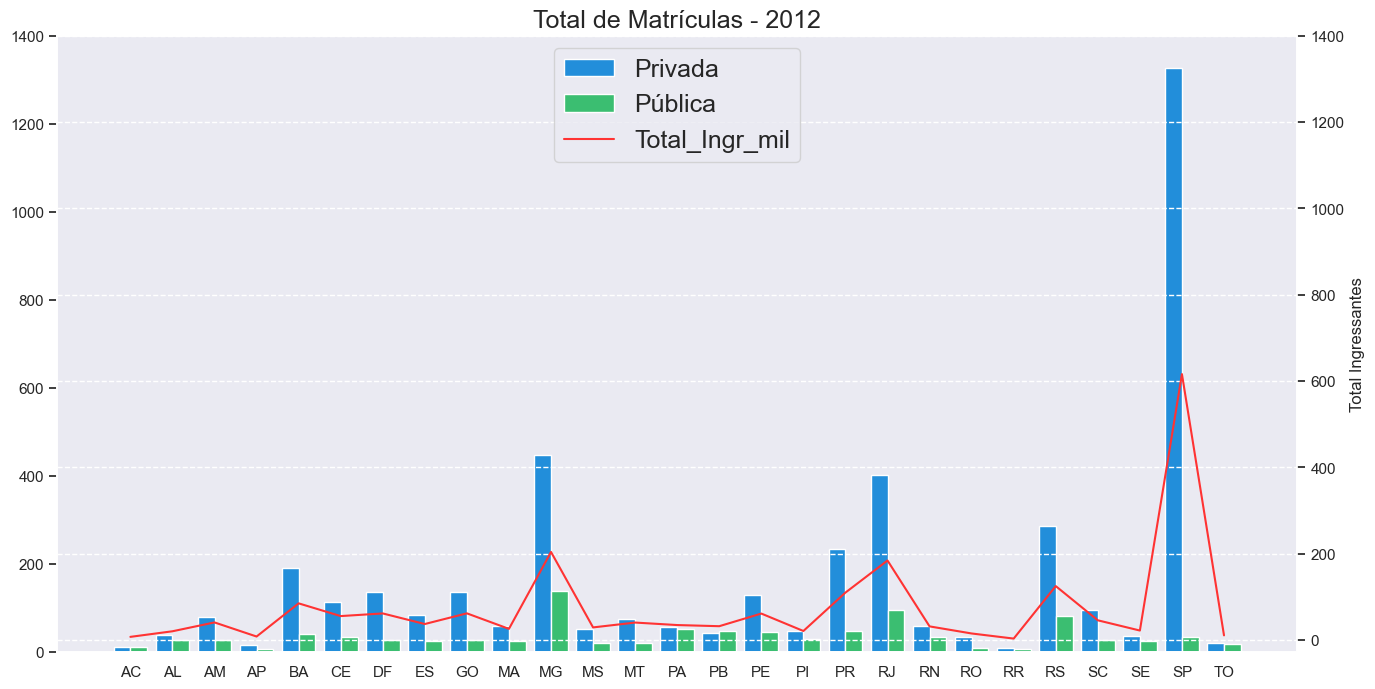

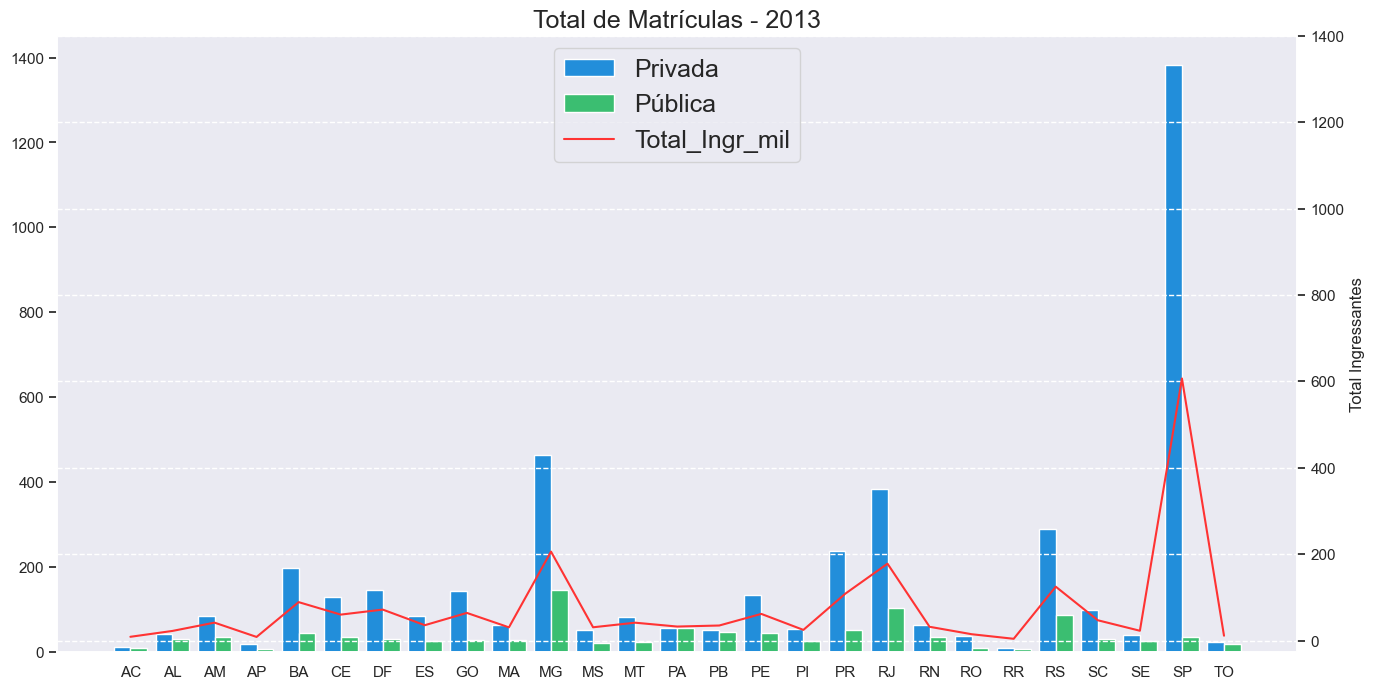

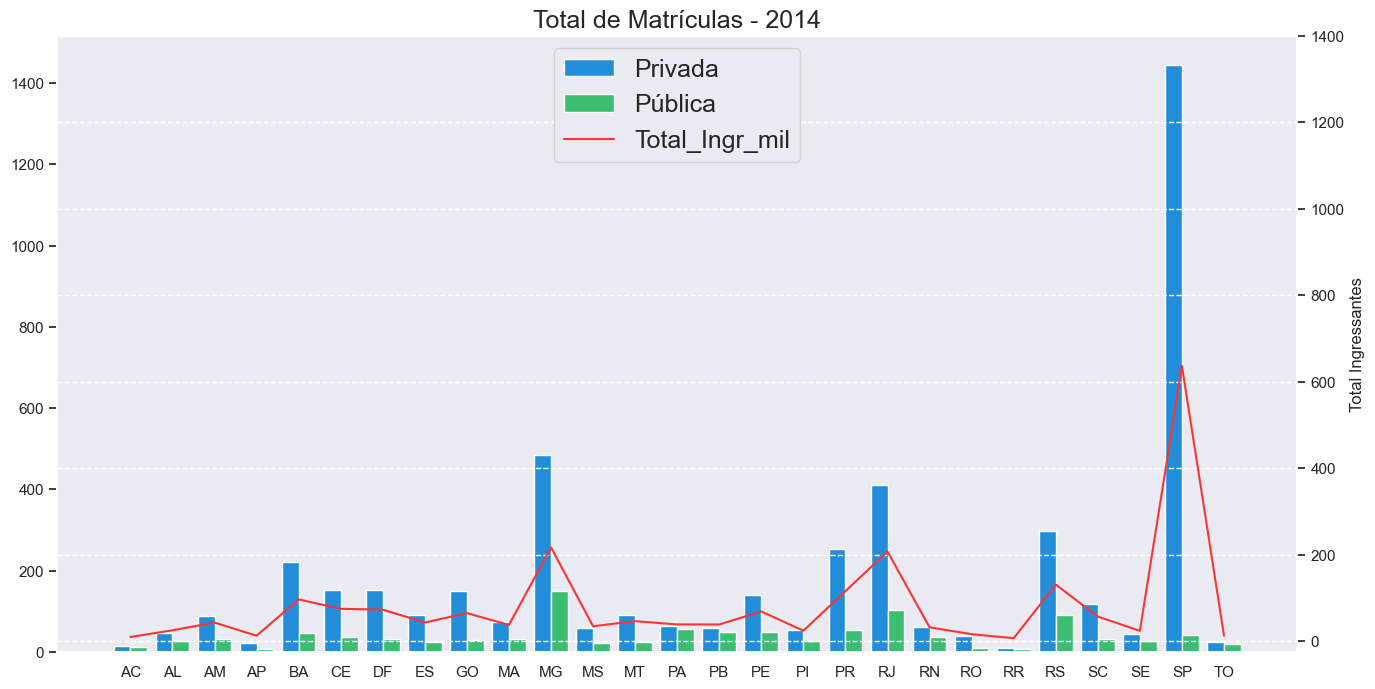

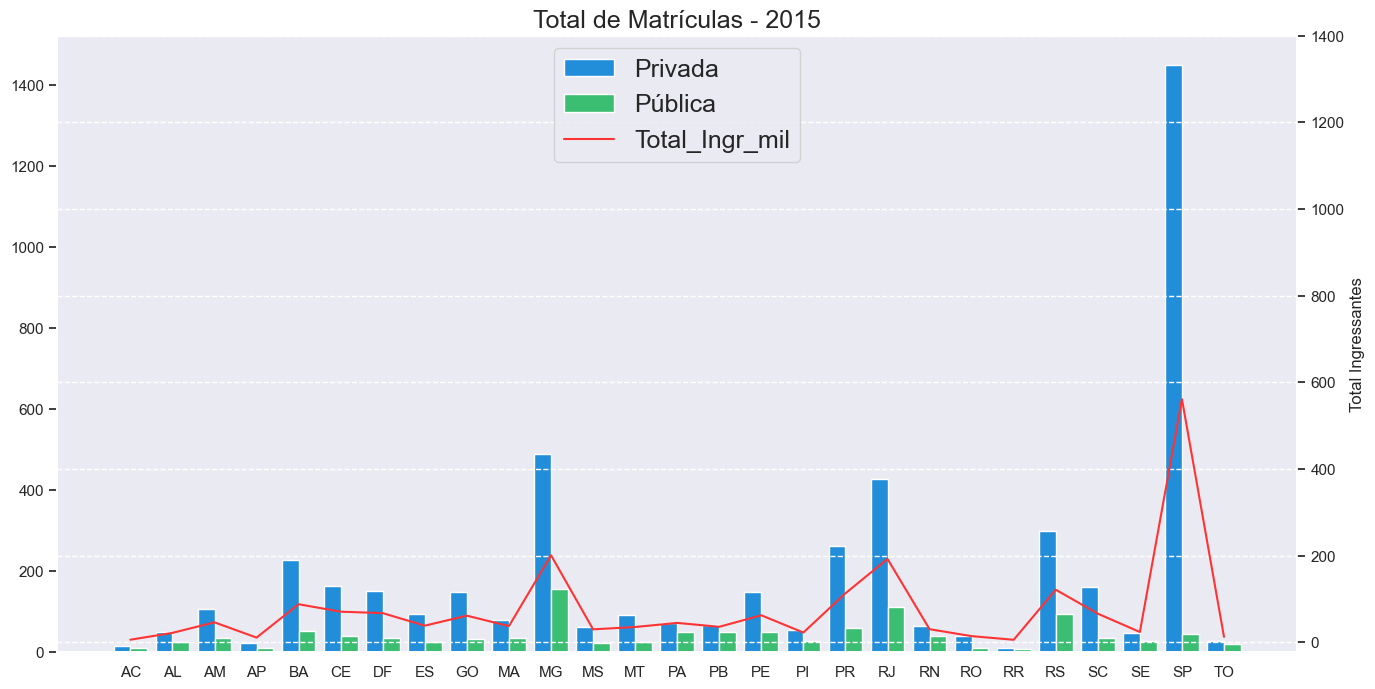

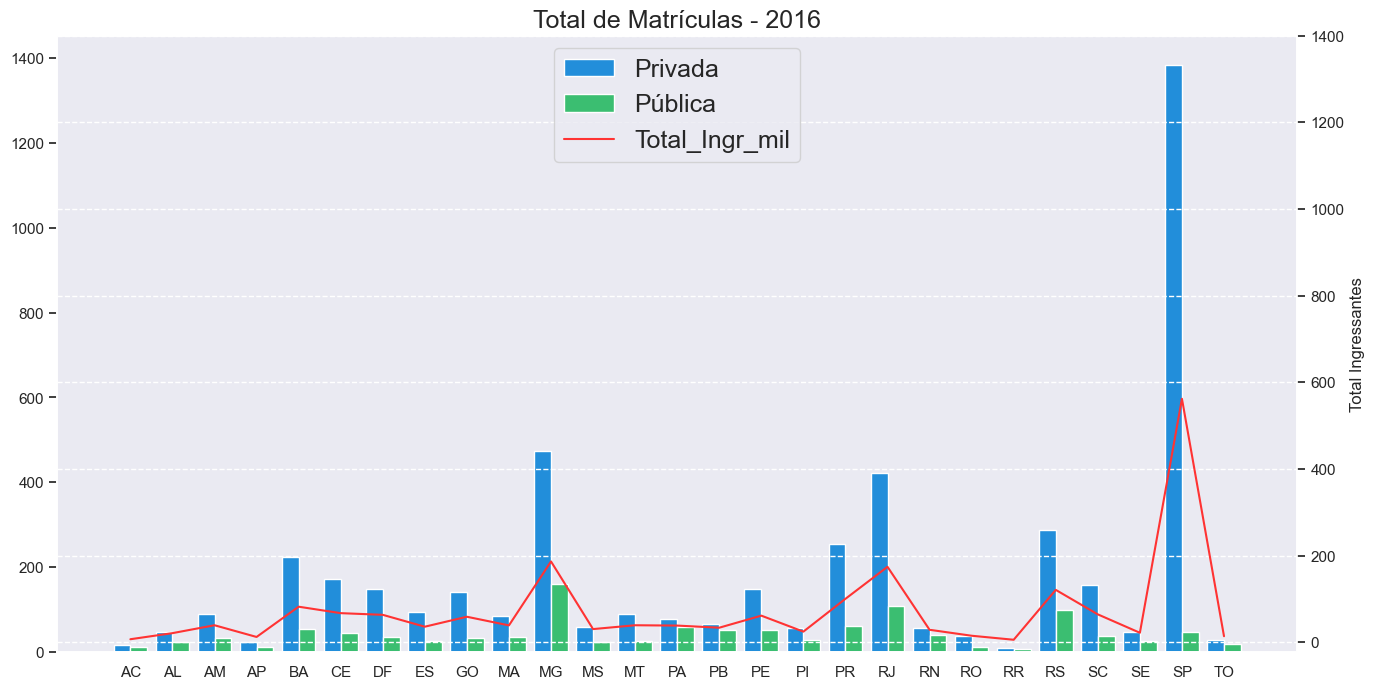

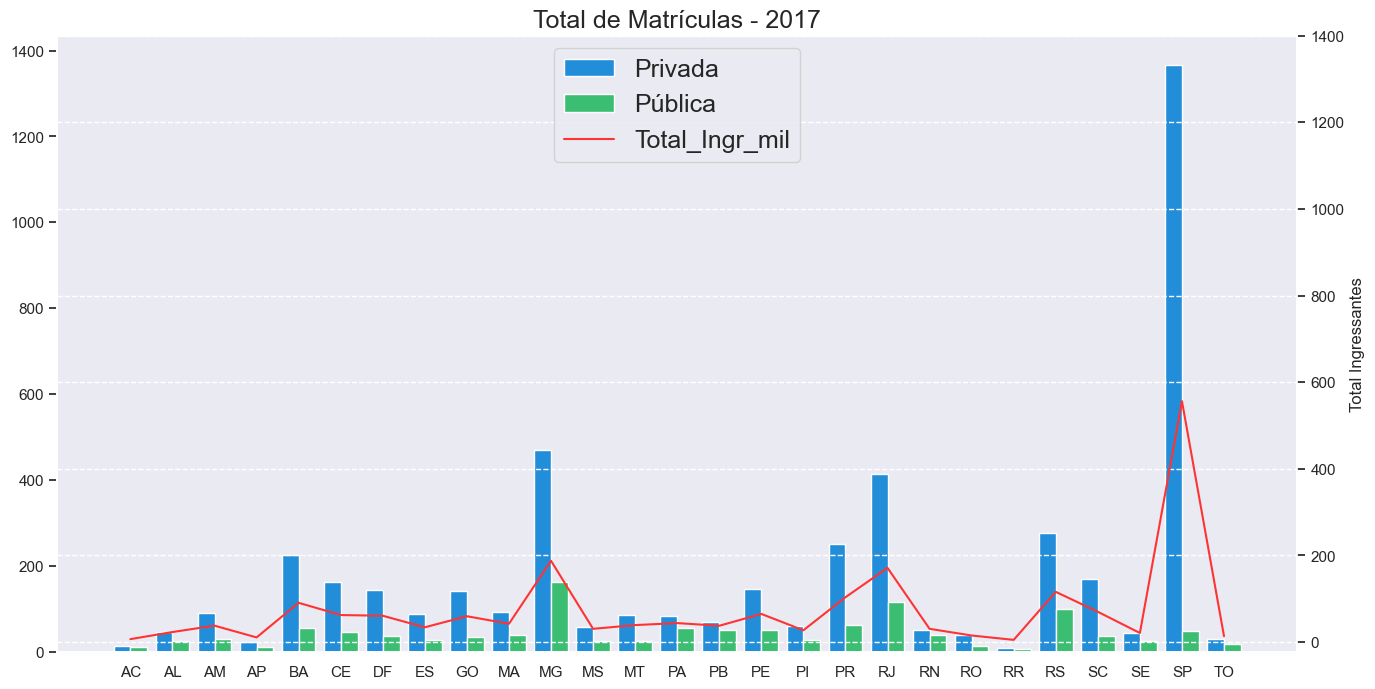

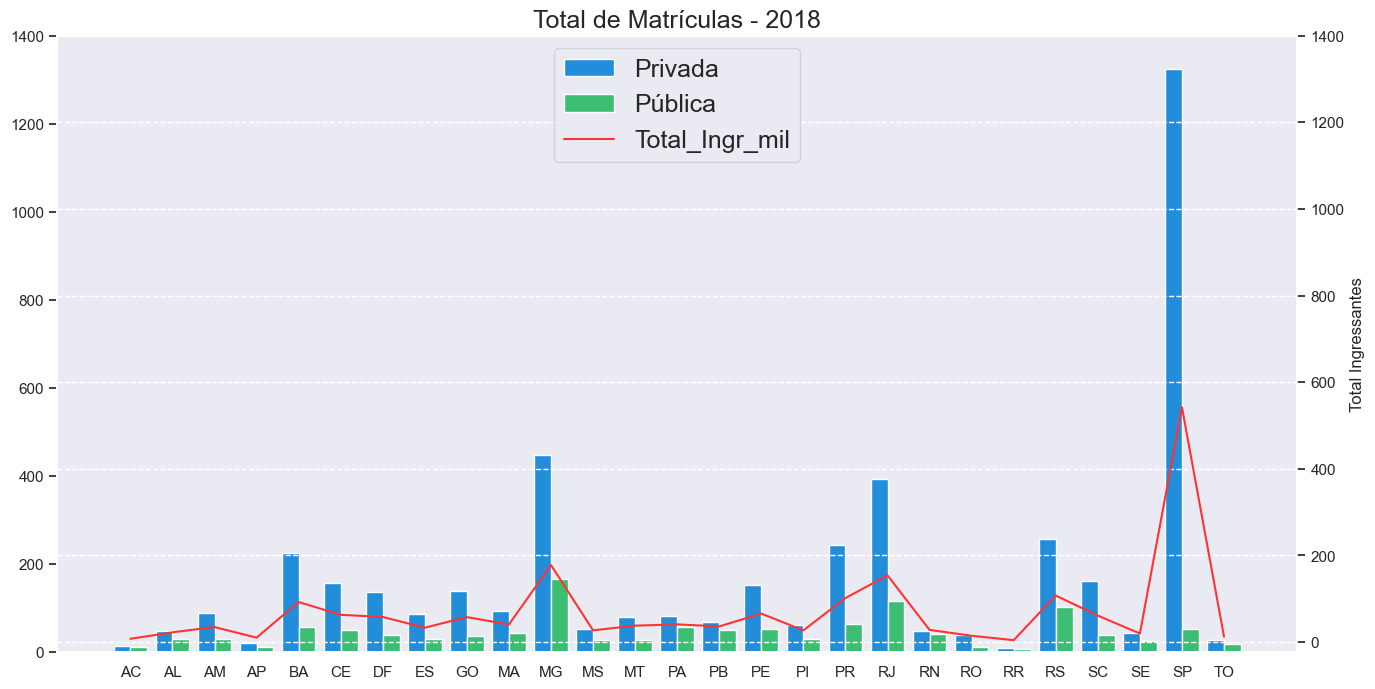

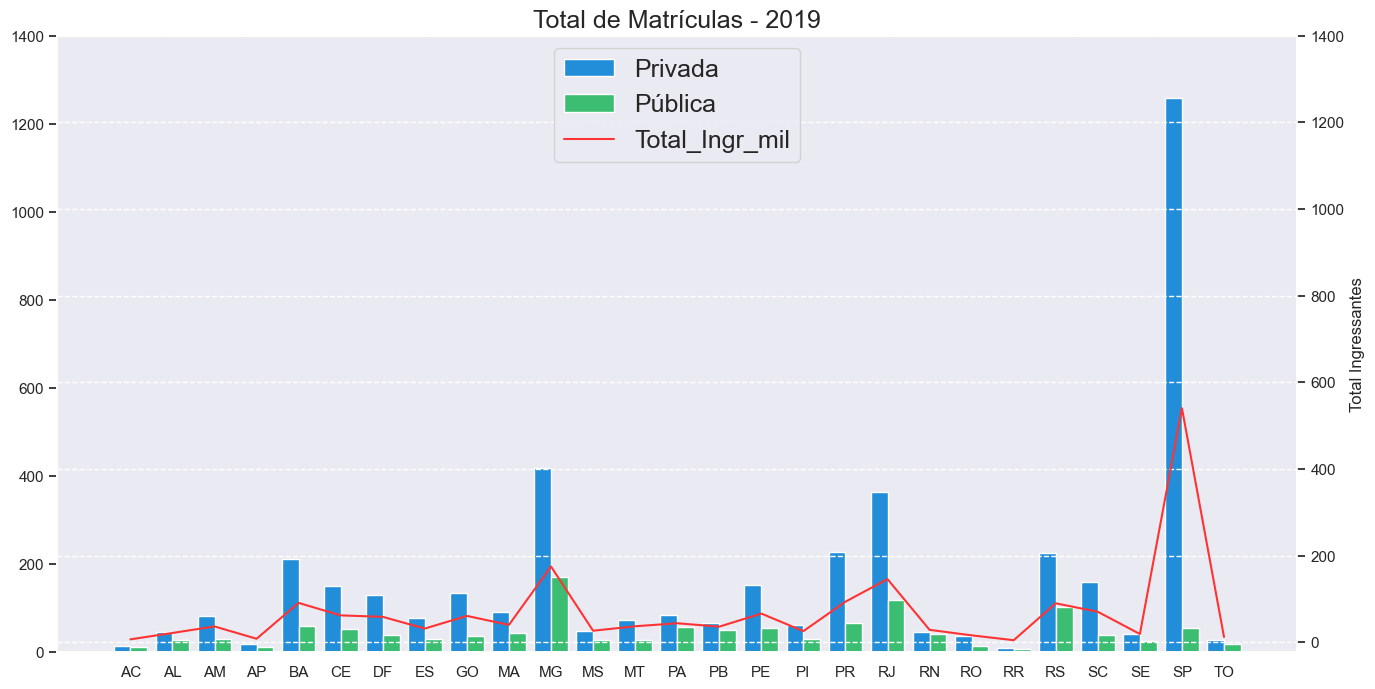

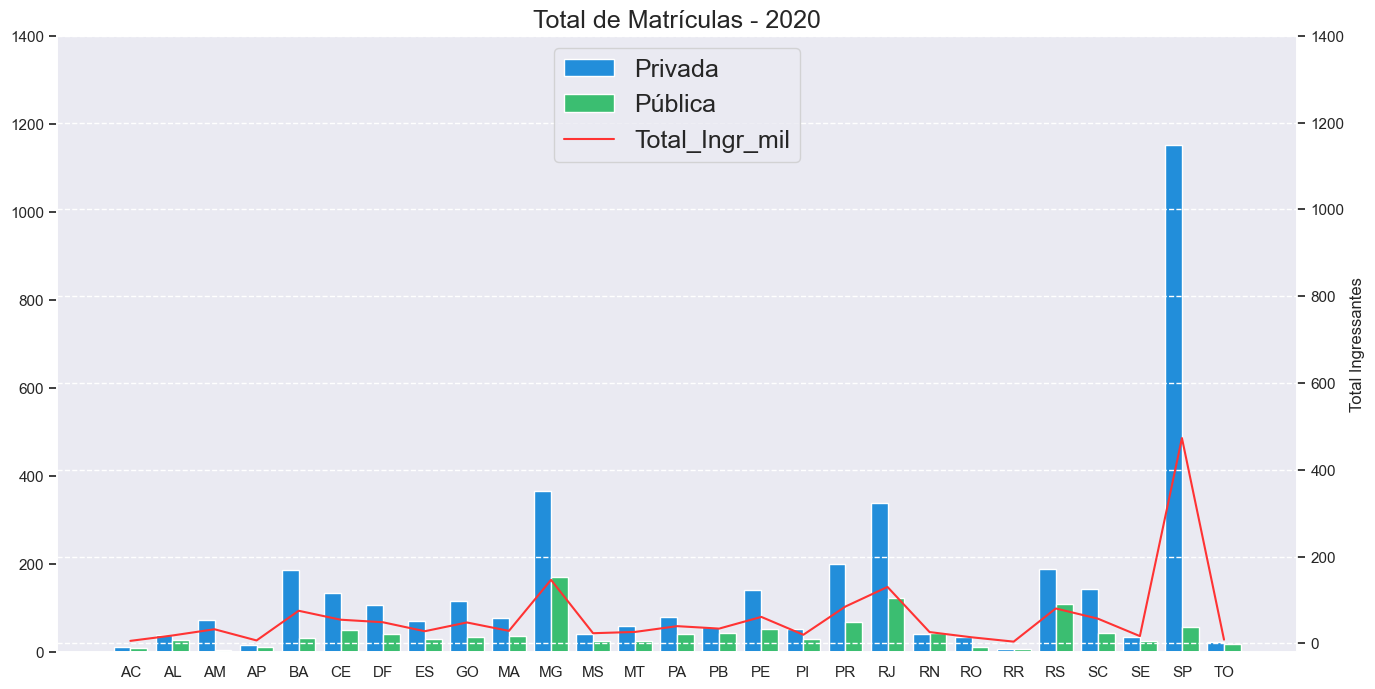

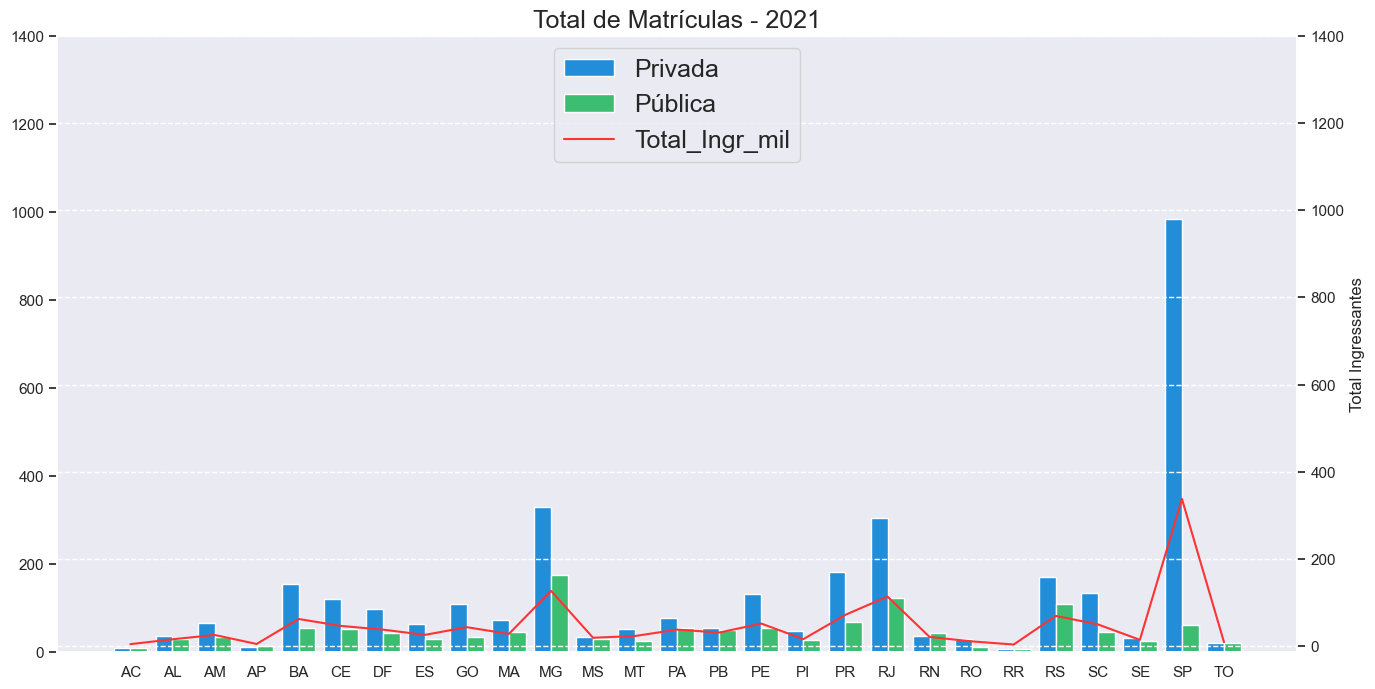

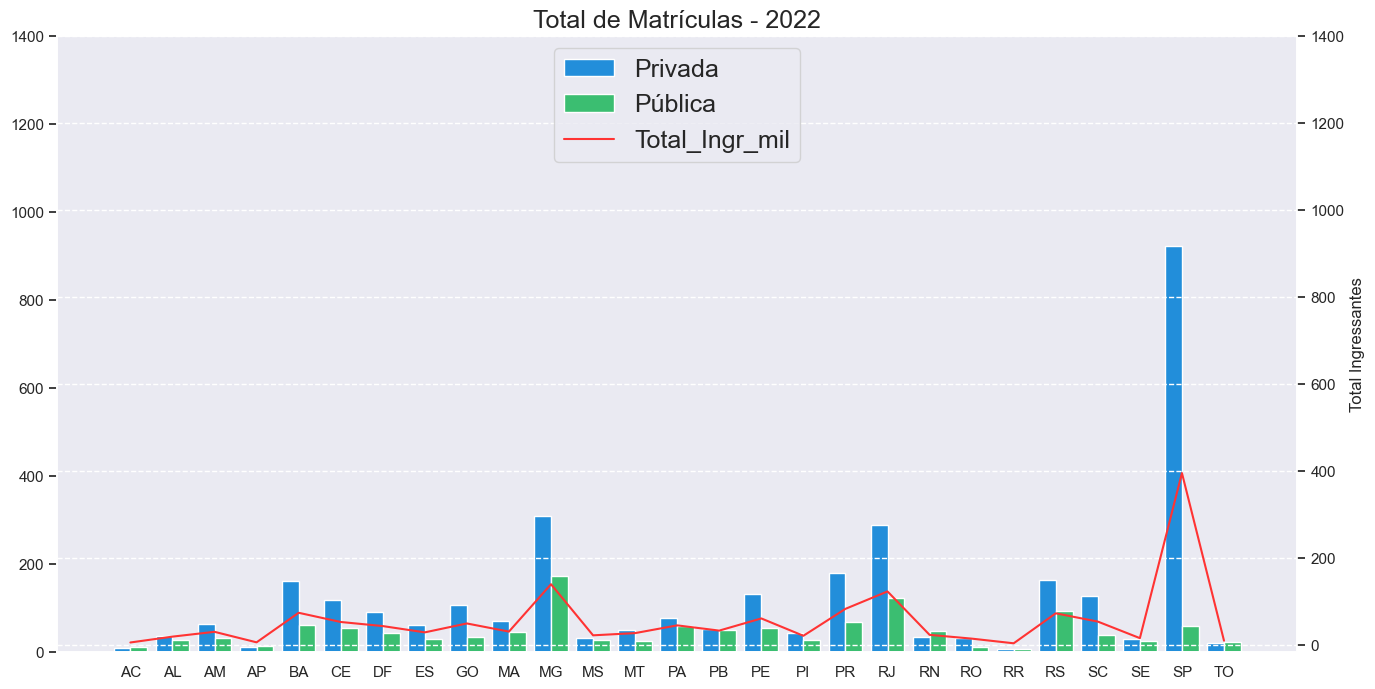

In [33]:
print(color.BOLD + color.BLUE + 'Total de Matrículas por UF e Rede de Ensino - Anos 2012 a 2022' + color.END)
cores = sns.color_palette("terrain")

for ano in range(2012, 2023, 1): # a = para cada ano 
    data = distr_matr_uf_re[distr_matr_uf_re['NU_ANO_CENSO']==ano].sort_values(by='SG_UF', ascending=True)
    f, axes = plt.subplots(1, 1,  figsize=(16, 8))
    g = sns.barplot(x='SG_UF', y='Total_Mat_mil', hue='TIPO_INST', data=data, orient='v', ax=axes, palette = cores)
    
    titulo = 'Total de Matrículas - ' + str(ano)
    
    axes.set_title(titulo, fontsize=18)
    major_yticks = np.arange(0, 1600, 200)
    axes.set_yticks(major_yticks)
    axes.set(xlabel=''); axes.set(ylabel='')
    axes.legend(loc='upper center', fontsize=18).set_visible(False)
    axes.grid(visible=False)
    
    ax2 = axes.twinx()
    dados2 = tot_ing_uf[tot_ing_uf['NU_ANO_CENSO']==ano].sort_values(by='SG_UF', ascending=True)
    ax2.plot(dados2['SG_UF'], dados2['Total_Ingr_mil'],color='#ff3333', label='Total_Ingr_mil')
    ax2.set_ylabel("Total Ingressantes")
    ax2.set_yticks(major_yticks)
    ax2.grid(visible=True, linestyle = "dashed", color='white')
    
    lines1, labels1 = axes.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper center", fontsize=18)
    
    plt.show()

## Grafico - Evolução Matriculas x Ingressantes (Animado)

In [34]:
ibge_uf = ibge.groupby(['REGIAO','SIGLA_UF', 'NOME_UF'])['POP_2022'].sum().reset_index()
ibge_uf['POP_2022_log10'] = np.log10(ibge_uf['POP_2022'])
ibge_uf['POP_2022_log2'] = np.log2(ibge_uf['POP_2022'])

display(ibge_uf.sort_values(by='POP_2022', ascending=False).head())
ibge_uf.sort_values(by='POP_2022', ascending=True).head()

REGIAO SIGLA_UF         NOME_UF  POP_2022  POP_2022_log10  POP_2022_log2
26     SE       SP       São Paulo  46024937            7.66          25.46
24     SE       MG    Minas Gerais  20732660            7.32          24.31
25     SE       RJ  Rio de Janeiro  16615526            7.22          23.99
12     NE       BA           Bahia  14659023            7.17          23.81
20      S       PR          Paraná  11835379            7.07          23.50

REGIAO SIGLA_UF    NOME_UF  POP_2022  POP_2022_log10  POP_2022_log2
9       N       RR    Roraima    634805            5.80          19.28
6       N       AP      Amapá    774268            5.89          19.56
4       N       AC       Acre    829780            5.92          19.66
10      N       TO  Tocantins   1584306            6.20          20.60
8       N       RO   Rondônia   1616379            6.21          20.62

In [35]:
df_all_ibge = pd.merge(df_all,
                      ibge_uf[['SIGLA_UF','POP_2022','POP_2022_log10', 'POP_2022_log2']],
                       left_on = ['SG_UF'],
                       right_on = ['SIGLA_UF'],
                       how='inner',
                       indicator=True)

display(df_all_ibge['_merge'].value_counts()) # para assegurar que todos os dados foram preenchidos

cols_delete = ['_merge', 'SIGLA_UF']
for c in cols_delete:
    del df_all_ibge[c] 

_merge
both          318251
left_only          0
right_only         0
Name: count, dtype: int64

In [36]:
df_evol_mat_ingr = df_all_ibge.groupby(['NU_ANO_CENSO', 'NO_REGIAO', 'SG_UF','POP_2022','POP_2022_log10','POP_2022_log2','TIPO_INST'])\
                        .agg({'QT_MAT':'sum','QT_ING':'sum', 'QT_CURSO':'count'})
df_evol_mat_ingr = df_evol_mat_ingr.reset_index().rename(columns={'QT_MAT':'Total_Mat', 
                                                                  'QT_ING':'Total_Ing',
                                                                 'QT_CURSO':'Total_Cursos'})
df_evol_mat_ingr.head()

NU_ANO_CENSO     NO_REGIAO SG_UF  POP_2022  POP_2022_log10  POP_2022_log2  \
0          2012  Centro-Oeste    DF   2923369            6.47          21.48   
1          2012  Centro-Oeste    DF   2923369            6.47          21.48   
2          2012  Centro-Oeste    GO   6950976            6.84          22.73   
3          2012  Centro-Oeste    GO   6950976            6.84          22.73   
4          2012  Centro-Oeste    MS   2833742            6.45          21.43   

  TIPO_INST  Total_Mat  Total_Ing  Total_Cursos  
0   Privada  136522.00   53126.00           511  
1   Pública   27895.00    8817.00           133  
2   Privada  135580.00   53038.00           505  
3   Pública   27520.00    9102.00           202  
4   Privada   51705.00   21970.00           254

In [37]:
df_evol_mat_ingr[df_evol_mat_ingr['SG_UF']=='AM'][['NU_ANO_CENSO','TIPO_INST','Total_Mat','Total_Ing']]\
.sort_values(by='NU_ANO_CENSO')

NU_ANO_CENSO TIPO_INST  Total_Mat  Total_Ing
28           2012   Privada   78813.00   35340.00
29           2012   Pública   27694.00    5765.00
82           2013   Privada   83721.00   35607.00
83           2013   Pública   34627.00    6238.00
136          2014   Privada   88793.00   36025.00
137          2014   Pública   31063.00    6500.00
190          2015   Privada  104653.00   39221.00
191          2015   Pública   34736.00    7125.00
244          2016   Privada   89644.00   33257.00
245          2016   Pública   31774.00    6079.00
299          2017   Pública   29967.00    6105.00
298          2017   Privada   90109.00   31890.00
352          2018   Privada   88010.00   28504.00
353          2018   Pública   29100.00    6259.00
406          2019   Privada   80953.00   30567.00
407          2019   Pública   29260.00    5878.00
460          2020   Privada   71760.00   27179.00
461          2020   Pública    3614.00    5203.00
514          2021   Privada   64866.00   22377.00
515          2021   Pública   32656.00    3426.00
568          2022   Privada   62288.00   27138.00
569          2022   Pública   31765.00    3043.00

In [39]:
#df_evol_mat_ingr[df_evol_mat_ingr['SG_UF']=='AP']
#df_all[(df_all['SG_UF']=='AC') & (df_all['NU_ANO_CENSO']==2012)].groupby(['CO_IES'])['QT_CURSO'].count()

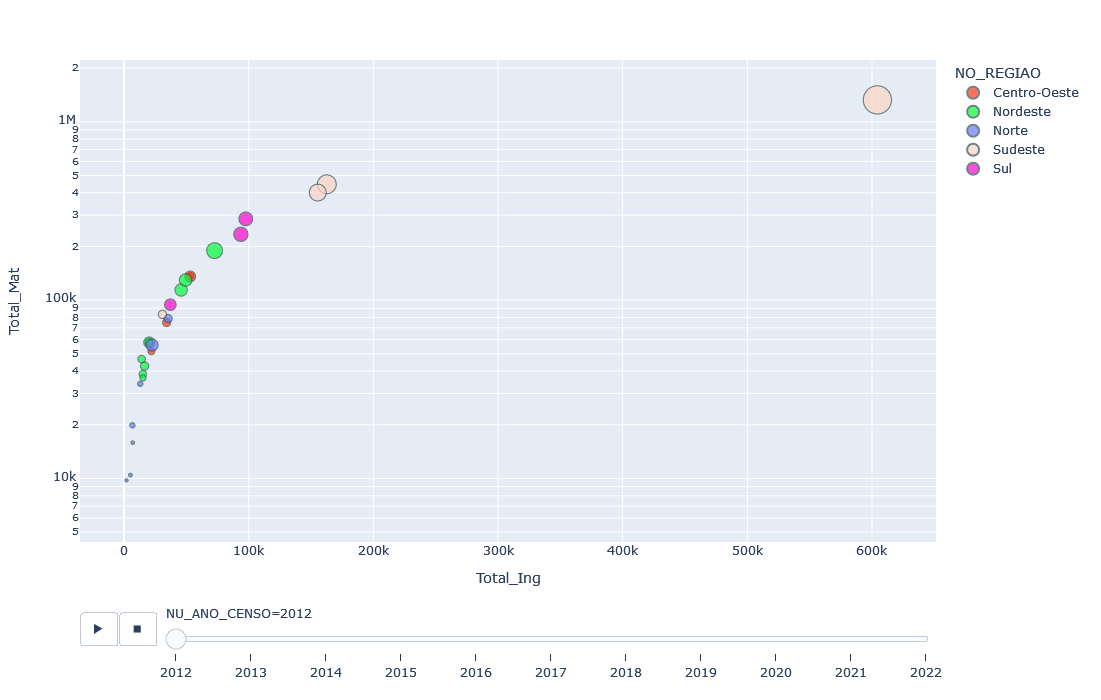

In [40]:
df = df_evol_mat_ingr
df_SE = df_evol_mat_ingr[df_evol_mat_ingr['NO_REGIAO']=='Sudeste']
df_NE = df_evol_mat_ingr[df_evol_mat_ingr['NO_REGIAO']=='Norte']

fig = px.scatter(df, x='Total_Ing', y='Total_Mat', 
                 #size='Total_Cursos', 
                 size='POP_2022',
                 color='NO_REGIAO', #symbol='TIPO_INST', symbol_sequence=['star','circle'], 
                 animation_frame='NU_ANO_CENSO', 
                 animation_group='SG_UF', 
                 hover_name='SG_UF',
                 log_x=False, log_y=True, width=1000, height=700,
                 #labels=dict(POP2013_Peso='PesoPop',Soma_ValorContr='Valor total dos Contratos no Municipio'),
                 color_discrete_sequence=px.colors.qualitative.Light24)

fig.update_traces(marker=dict(line=dict(width=1.1,color='DarkSlateGrey')),selector=dict(mode='markers'))
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1500
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 1000
fig.show()

# Graficos Ingressantes

## Evolução Total Ingressantes por Ano/ Tipo de Rede

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO TIPO_INST      Total
0          2012   Privada 1704682.00
1          2012   Pública  293936.00
2          2013   Privada 1732254.00
3          2013   Pública  289980.00
4          2014   Privada 1877880.00

Soma da coluna QT_ING nos anos de 2012 a 2022: 20241266.0


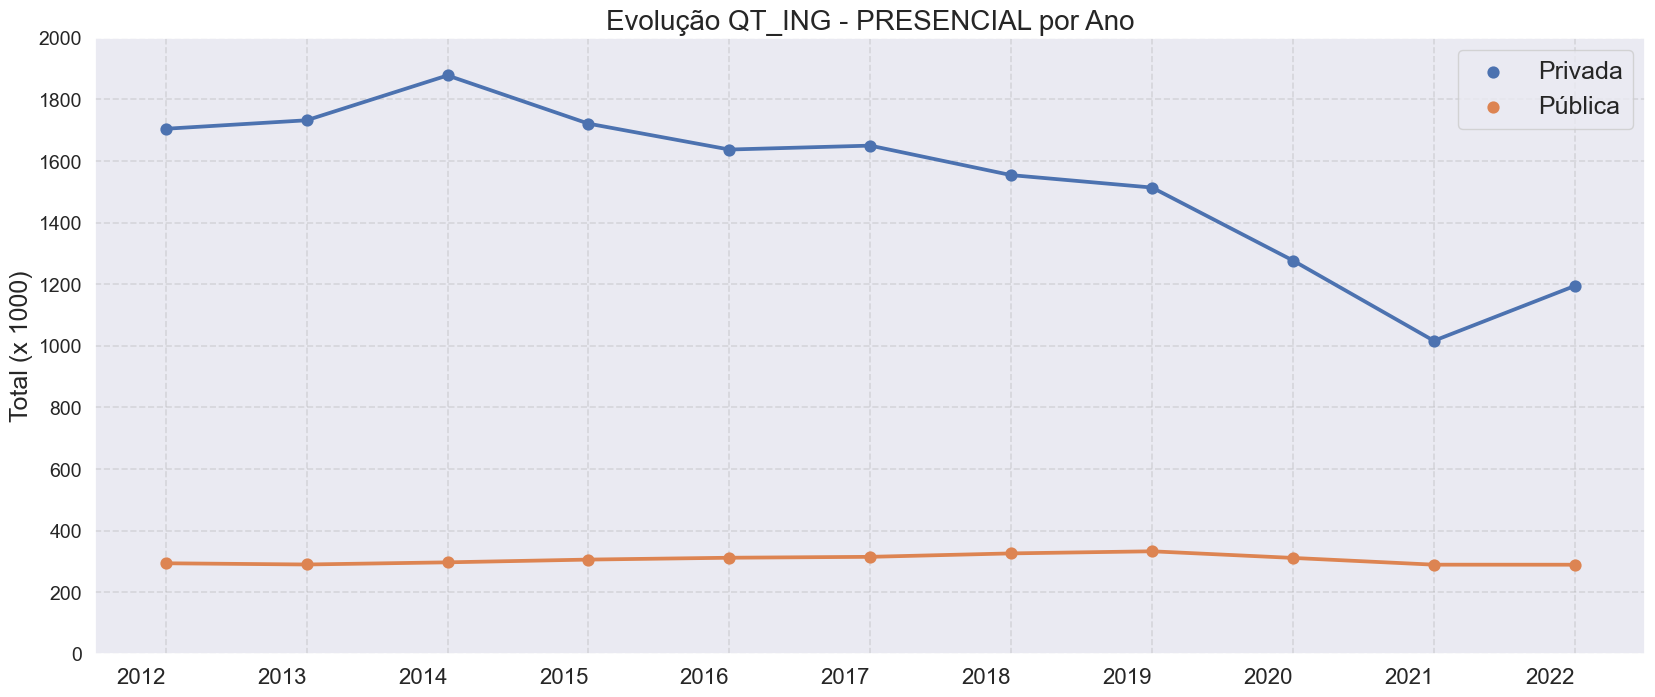

In [42]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'TIPO_INST'
col_soma = 'QT_ING'
legenda_outside = 'N'

gerar_plot_evol_ano(df_all, col_ano, col_grupo, col_soma, legenda_outside)

## Evolução Total Ingressantes por Ano/ Grau Academico

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO Tipo_Grau_Acad      Total
0          2012    Bacharelado 1435112.00
1          2012   Licenciatura  243072.00
2          2012    Tecnológico  320434.00
3          2013    Bacharelado 1479142.00
4          2013   Licenciatura  243244.00

Soma da coluna QT_ING nos anos de 2012 a 2022: 20241266.0


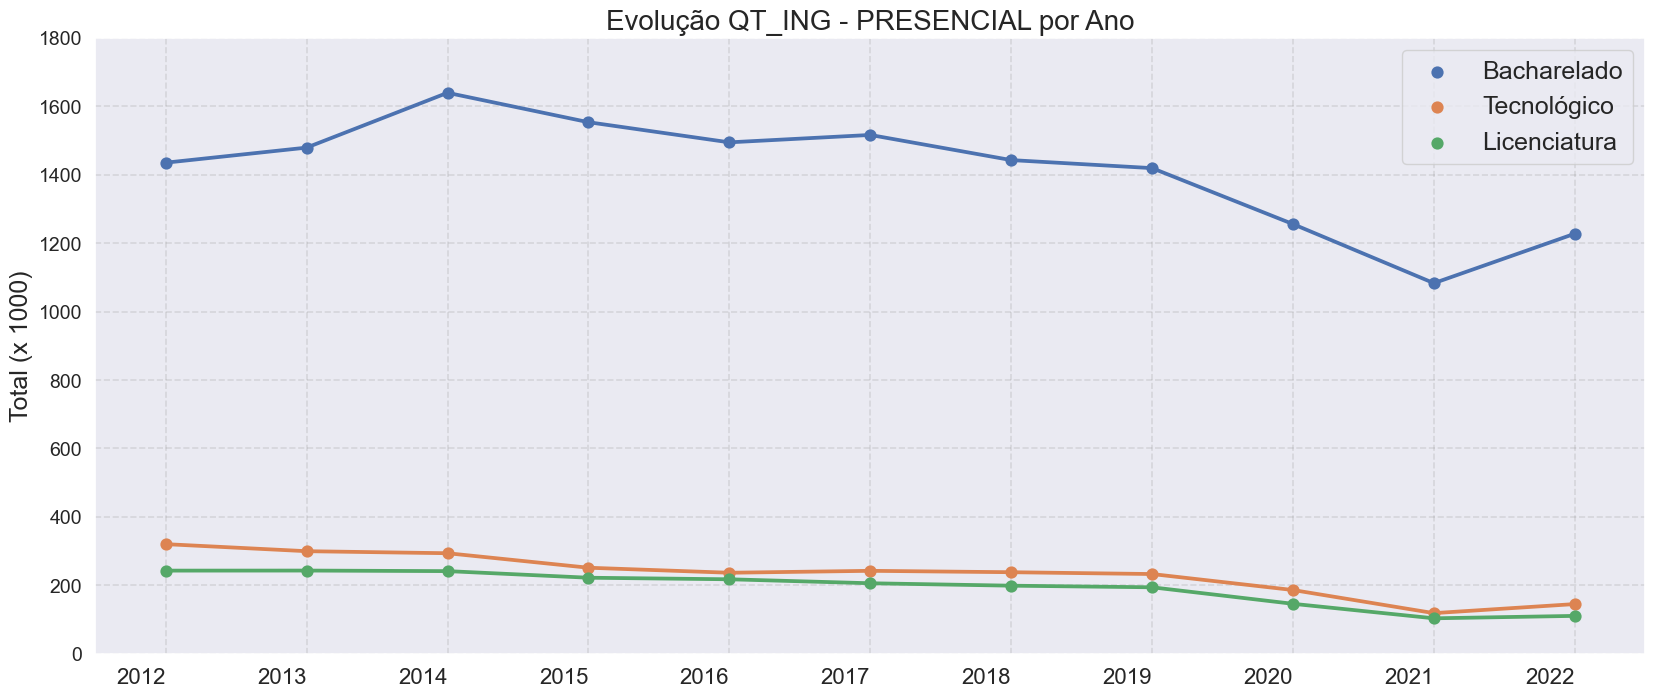

In [43]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Tipo_Grau_Acad' 
col_soma = 'QT_ING'
legenda_outside='N'

gerar_plot_evol_ano(df_all, col_ano, col_grupo, col_soma, legenda_outside)

## Evolução Total Ingressantes por Ano / Area Curso

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO                                          NO_CINE_AREA_GERAL  \
0          2012              Agricultura, silvicultura, pesca e veterinária   
1          2012                                         Artes e humanidades   
2          2012                 Ciências naturais, matemática e estatística   
3          2012                  Ciências sociais, comunicação e informação   
4          2012  Computação e Tecnologias da Informação e Comunicação (TIC)   

      Total  
0  43625.00  
1  59913.00  
2  34455.00  
3 108320.00  
4 104270.00

Soma da coluna QT_ING nos anos de 2012 a 2022: 20240792.0


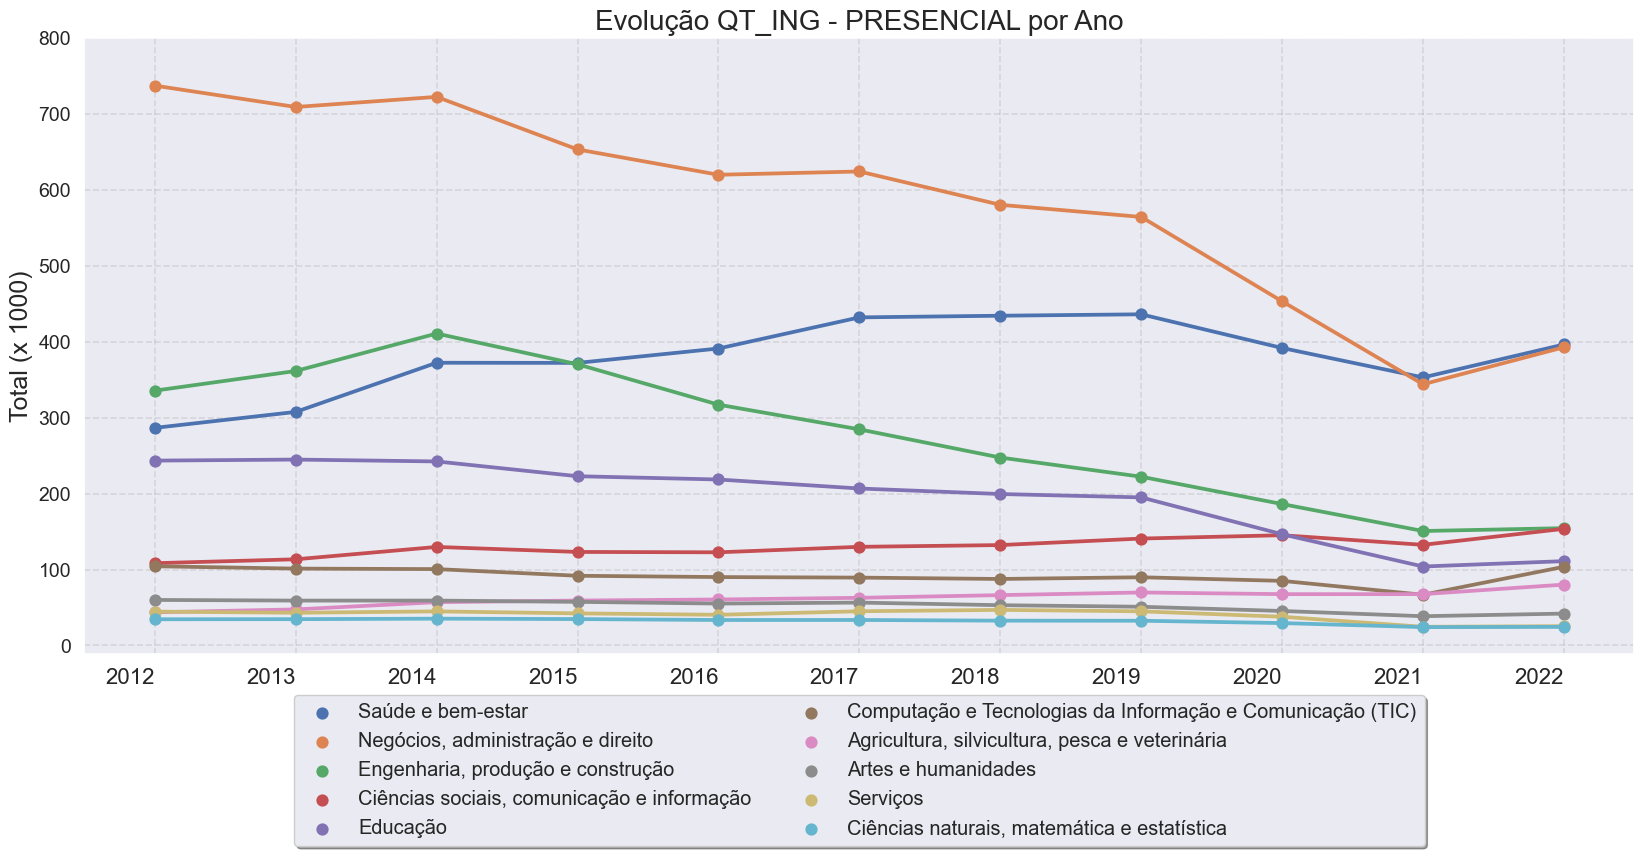

In [44]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'NO_CINE_AREA_GERAL'
col_soma = 'QT_ING'
legenda_outside = 'S'

# retirar area especifica: Programas básicos
#df_all['NO_CINE_AREA_GERAL'].value_counts()
df_areas = df_all[~df_all['NO_CINE_AREA_GERAL'].isin(['Programas básicos'])]

gerar_plot_evol_ano(df_areas, col_ano, col_grupo, col_soma, legenda_outside)

## Evolução Total Ingressantes por Ano / Idade

### Preparação dos dados

In [45]:
serie_ingr_faixas_t1 = df_all.melt(id_vars=['NU_ANO_CENSO','CO_IES','NO_CURSO','QT_ING'], var_name='Faixa_etaria', 
                                   value_name = 'Total_Ingress',
                                   value_vars=['QT_ING_0_17', 'QT_ING_18_24', 'QT_ING_25_29', 'QT_ING_30_34',
                                               'QT_ING_35_39', 'QT_ING_40_49', 'QT_ING_50_59', 'QT_ING_60_MAIS'])
#display(serie_ingr_faixas_t1.head(5))
serie_ingr_faixas_t2 = serie_ingr_faixas_t1.groupby(['NU_ANO_CENSO', 'CO_IES','NO_CURSO','QT_ING','Faixa_etaria'])['Total_Ingress']\
                                            .sum().reset_index()
#display(serie_ingr_faixas_t2.head(5))

### Gráfico

In [46]:
serie_ingr_faixas = serie_ingr_faixas_t2.groupby(['NU_ANO_CENSO','Faixa_etaria'])['Total_Ingress'].sum().reset_index()

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO  Faixa_etaria      Total
0          2012   QT_ING_0_17   24517.00
1          2012  QT_ING_18_24 1215121.00
2          2012  QT_ING_25_29  344138.00
3          2012  QT_ING_30_34  199368.00
4          2012  QT_ING_35_39  102053.00

Soma da coluna Total_Ingress nos anos de 2012 a 2022: 20241266.0


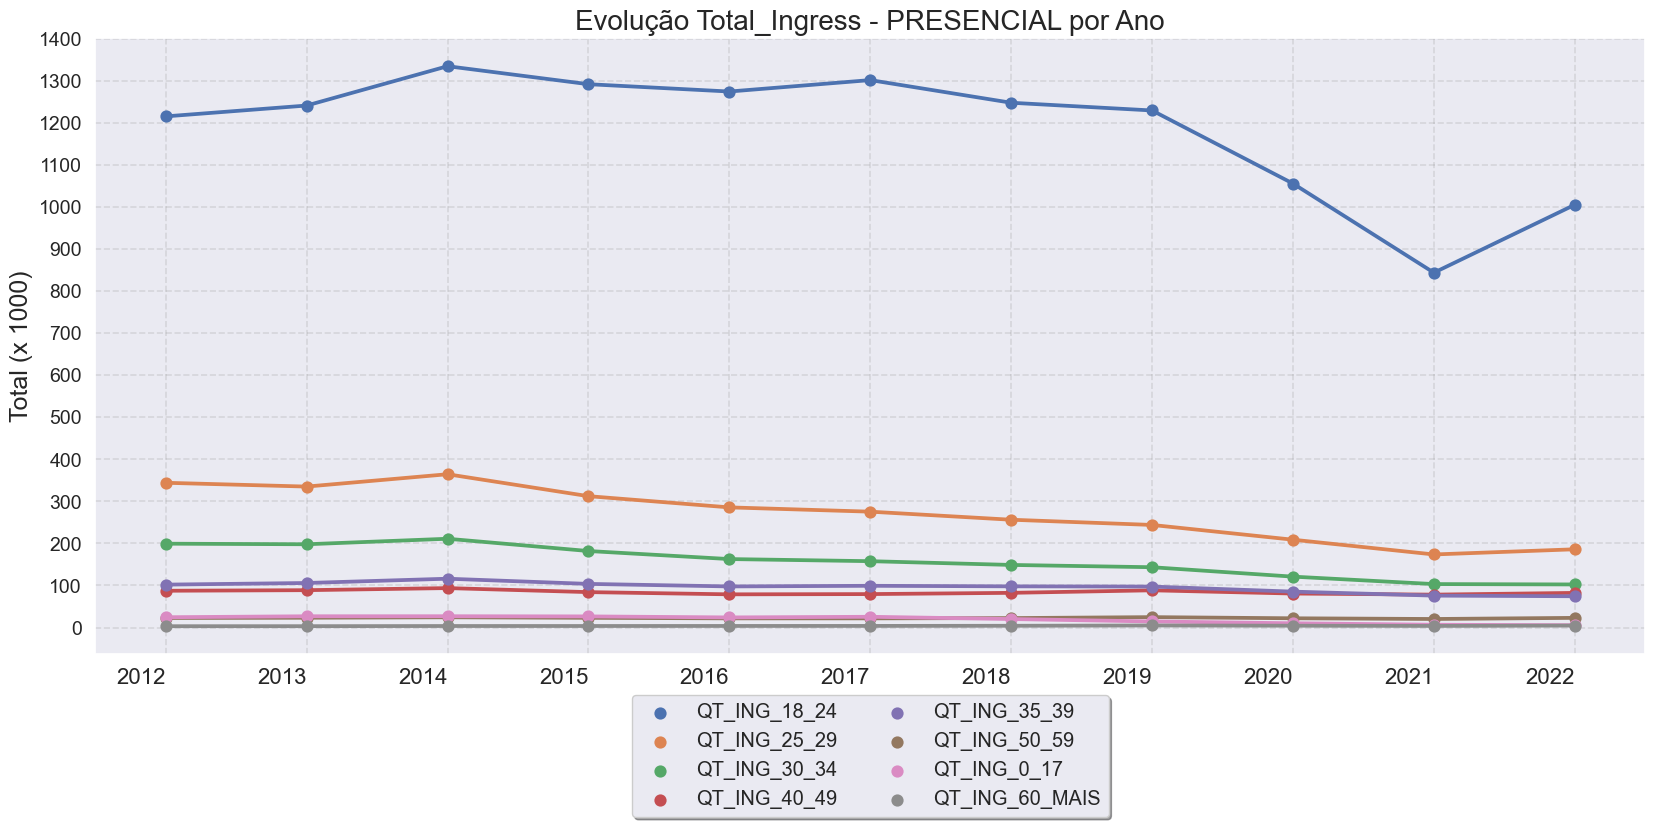

In [47]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Faixa_etaria'
col_soma = 'Total_Ingress'
legenda_outside = 'S'

gerar_plot_evol_ano(serie_ingr_faixas, col_ano, col_grupo, col_soma, legenda_outside)

# Graficos Concluintes

## Evolução Total Concluintes por Ano/ Tipo de Rede

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO TIPO_INST     Total
0          2012   Privada 673697.00
1          2012   Pública  96270.00
2          2013   Privada 623677.00
3          2013   Pública 107792.00
4          2014   Privada 611590.00

Soma da coluna QT_CONC nos anos de 2012 a 2022: 8757516.0


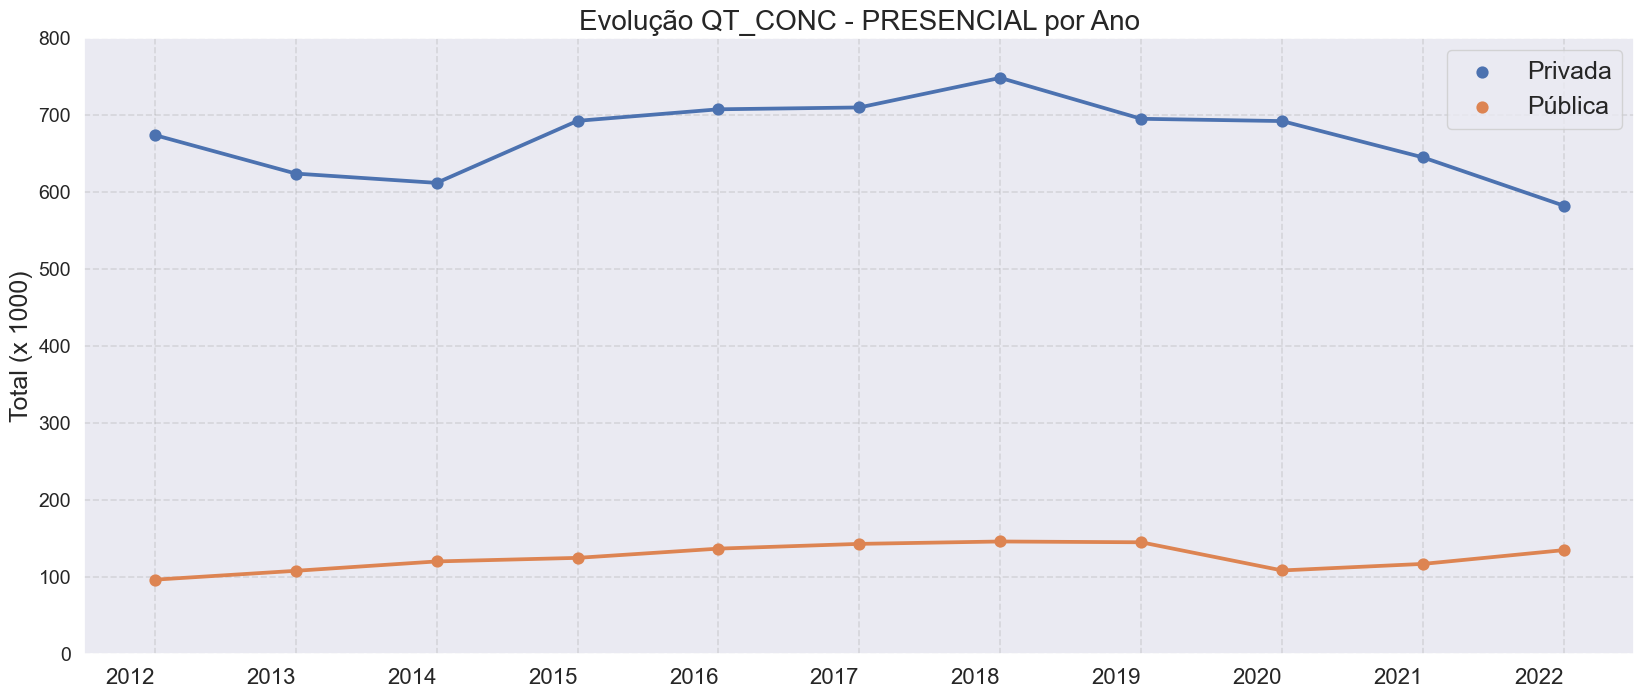

In [48]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'TIPO_INST' 
col_soma = 'QT_CONC'
legenda_outside = 'N'

gerar_plot_evol_ano(df_all, col_ano, col_grupo, col_soma, legenda_outside)

## Evolução Total Concluintes por Ano/ Grau Academico

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO Tipo_Grau_Acad     Total
0          2012    Bacharelado 531898.00
1          2012   Licenciatura 111756.00
2          2012    Tecnológico 126313.00
3          2013    Bacharelado 495448.00
4          2013   Licenciatura 107994.00

Soma da coluna QT_CONC nos anos de 2012 a 2022: 8757516.0


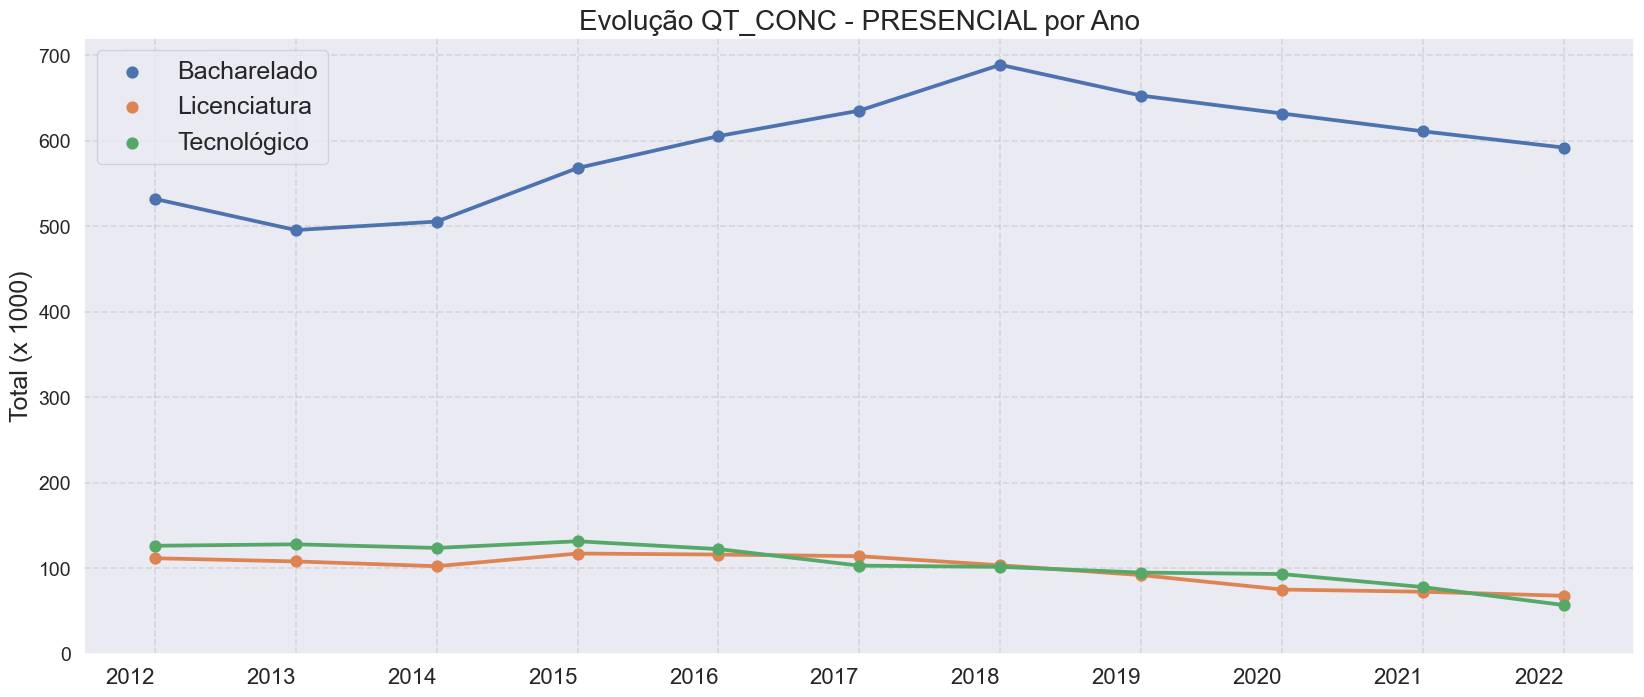

In [49]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Tipo_Grau_Acad' 
col_soma = 'QT_CONC'
legenda_outside='N'

gerar_plot_evol_ano(df_all, col_ano, col_grupo, col_soma, legenda_outside)

## Evolução Total Concluintes por Ano / Area Curso

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO                                          NO_CINE_AREA_GERAL  \
0          2012              Agricultura, silvicultura, pesca e veterinária   
1          2012                                         Artes e humanidades   
2          2012                 Ciências naturais, matemática e estatística   
3          2012                  Ciências sociais, comunicação e informação   
4          2012  Computação e Tecnologias da Informação e Comunicação (TIC)   

     Total  
0 13774.00  
1 22723.00  
2 11682.00  
3 39620.00  
4 34258.00

Soma da coluna QT_CONC nos anos de 2012 a 2022: 8757515.0


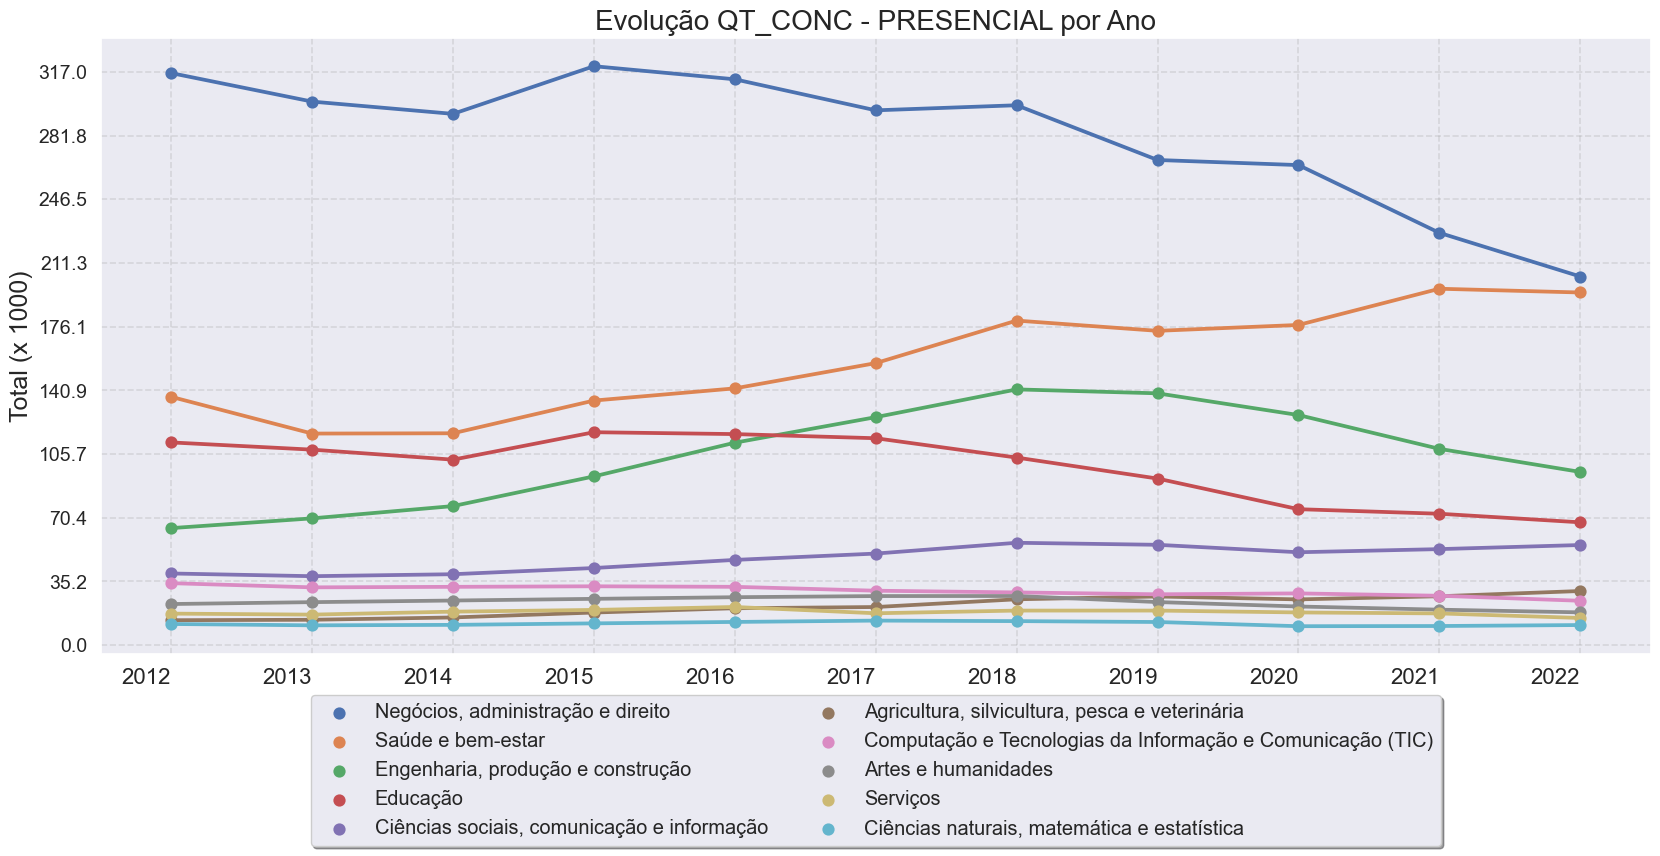

In [50]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'NO_CINE_AREA_GERAL'
col_soma = 'QT_CONC'
legenda_outside = 'S'

# retirar area especifica: Programas básicos
#df_all['NO_CINE_AREA_GERAL'].value_counts()
df_areas = df_all[~df_all['NO_CINE_AREA_GERAL'].isin(['Programas básicos'])]

gerar_plot_evol_ano(df_areas, col_ano, col_grupo, col_soma, legenda_outside)

## Evolução Total Concluintes por Ano / Idade

### Preparação dos dados

In [51]:
serie_concl_faixas_t1 = df_all.melt(id_vars=['NU_ANO_CENSO','CO_IES','NO_CURSO','QT_CONC'], var_name='Faixa_etaria', 
                                   value_name = 'Total_Concl',
                                   value_vars=['QT_CONC_0_17', 'QT_CONC_18_24', 'QT_CONC_25_29', 'QT_CONC_30_34',
                                               'QT_CONC_35_39', 'QT_CONC_40_49', 'QT_CONC_50_59', 'QT_CONC_60_MAIS'])
#display(serie_concl_faixas_t1.head(5))
serie_concl_faixas_t2 = serie_concl_faixas_t1.groupby(['NU_ANO_CENSO', 'CO_IES','NO_CURSO','QT_CONC','Faixa_etaria'])['Total_Concl']\
                                            .sum().reset_index()
#display(serie_concl_faixas_t2.head(5))

### Gráfico

In [52]:
serie_concl_faixas = serie_concl_faixas_t2.groupby(['NU_ANO_CENSO','Faixa_etaria'])['Total_Concl'].sum().reset_index()

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO   Faixa_etaria     Total
0          2012   QT_CONC_0_17      8.00
1          2012  QT_CONC_18_24 310851.00
2          2012  QT_CONC_25_29 219664.00
3          2012  QT_CONC_30_34 110680.00
4          2012  QT_CONC_35_39  57387.00

Soma da coluna Total_Concl nos anos de 2012 a 2022: 8757516.0


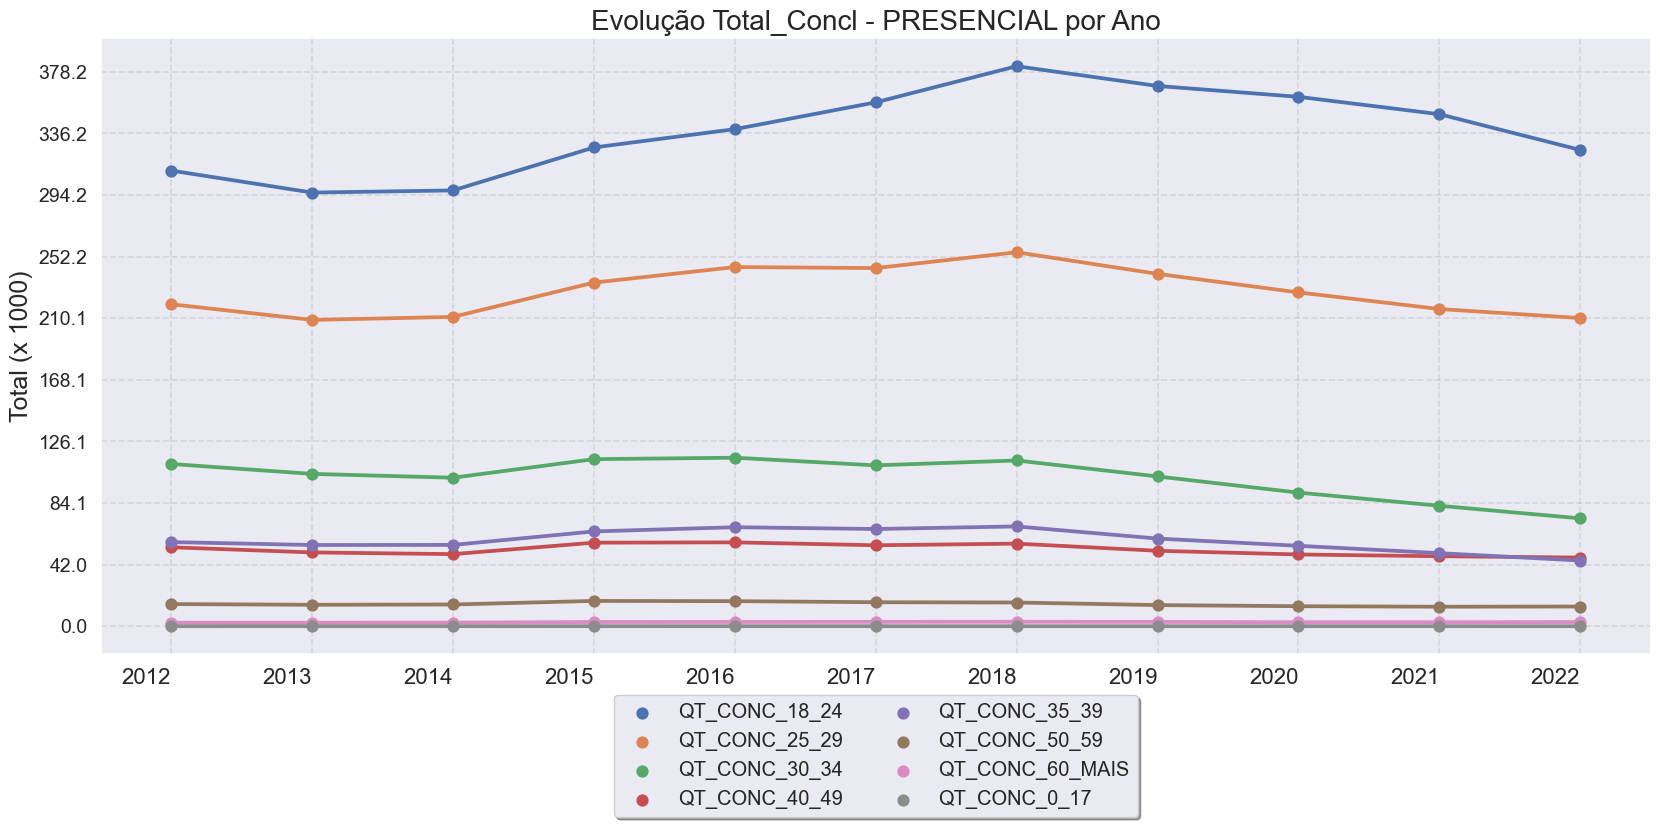

In [53]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Faixa_etaria'
col_soma = 'Total_Concl'
legenda_outside = 'S'

gerar_plot_evol_ano(serie_concl_faixas, col_ano, col_grupo, col_soma, legenda_outside)

# Graficos Consolidados

## Matriculas, Ingressos e Concluintes - por Faixa

### 0 a 17 anos

In [54]:
df1 = serie_matr_faixas[serie_matr_faixas['Faixa_etaria']=='QT_MAT_0_17'].rename(columns={'Total_MAT':'Total'})
df2 = serie_ingr_faixas[serie_ingr_faixas['Faixa_etaria']=='QT_ING_0_17'].rename(columns={'Total_Ingress':'Total'})
df3 = serie_concl_faixas[serie_concl_faixas['Faixa_etaria']=='QT_CONC_0_17'].rename(columns={'Total_Concl':'Total'})
serie_0_17 = pd.concat([df1, df2, df3])

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO  Faixa_etaria    Total
0          2012  QT_CONC_0_17     8.00
1          2012   QT_ING_0_17 24517.00
2          2012   QT_MAT_0_17 21789.00
3          2013  QT_CONC_0_17     3.00
4          2013   QT_ING_0_17 26850.00

Soma da coluna Total nos anos de 2012 a 2022: 398958.0


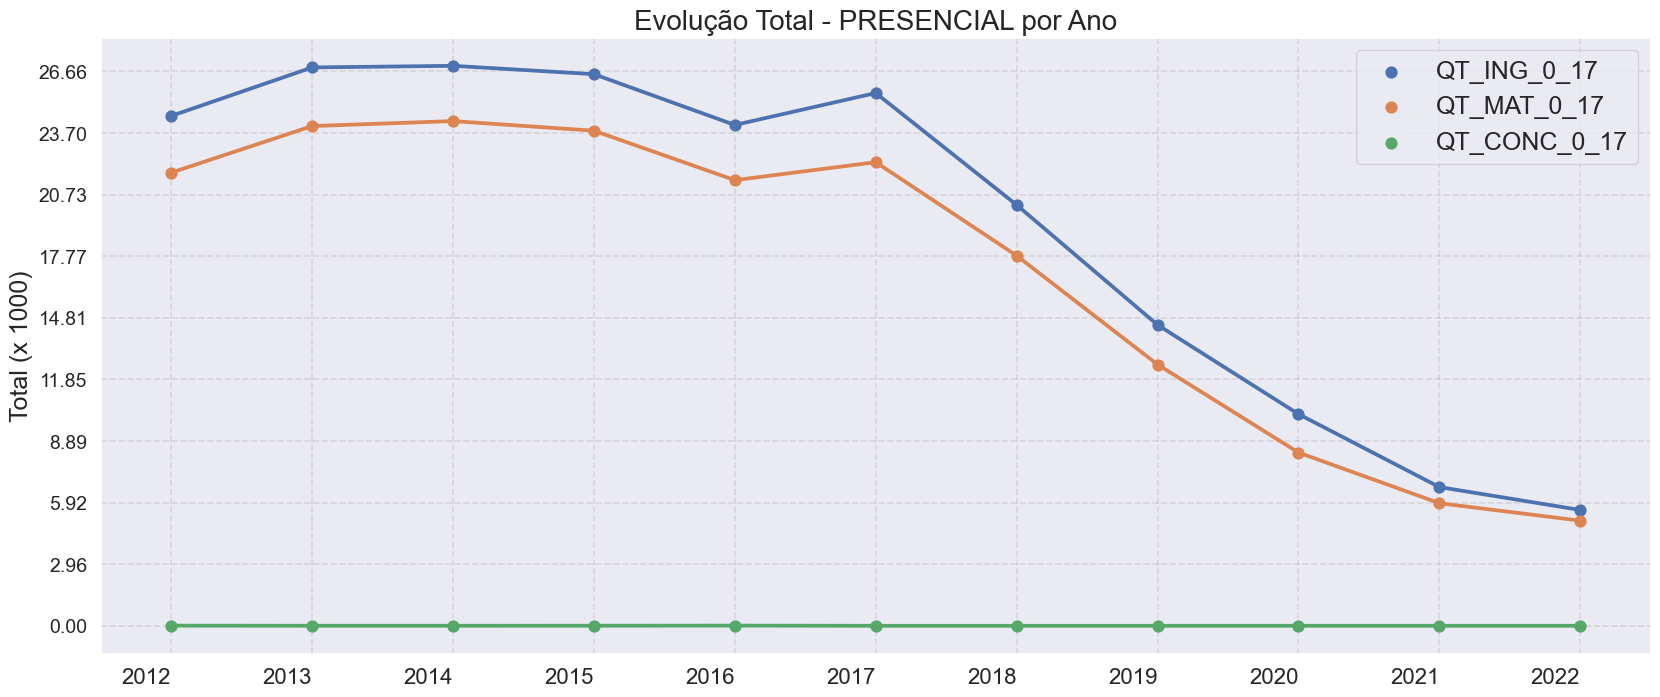

In [55]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Faixa_etaria'
col_soma = 'Total'
legenda_outside = 'N'

gerar_plot_evol_ano(serie_0_17, col_ano, col_grupo, col_soma, legenda_outside)

### 18 a 24 anos

In [56]:
df1 = serie_matr_faixas[serie_matr_faixas['Faixa_etaria']=='QT_MAT_18_24'].rename(columns={'Total_MAT':'Total'})
df2 = serie_ingr_faixas[serie_ingr_faixas['Faixa_etaria']=='QT_ING_18_24'].rename(columns={'Total_Ingress':'Total'})
df3 = serie_concl_faixas[serie_concl_faixas['Faixa_etaria']=='QT_CONC_18_24'].rename(columns={'Total_Concl':'Total'})
serie_18_24 = pd.concat([df1, df2, df3])

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO   Faixa_etaria      Total
0          2012  QT_CONC_18_24  310851.00
1          2012   QT_ING_18_24 1215121.00
2          2012   QT_MAT_18_24 2890236.00
3          2013  QT_CONC_18_24  295838.00
4          2013   QT_ING_18_24 1240889.00

Soma da coluna Total nos anos de 2012 a 2022: 51124938.0


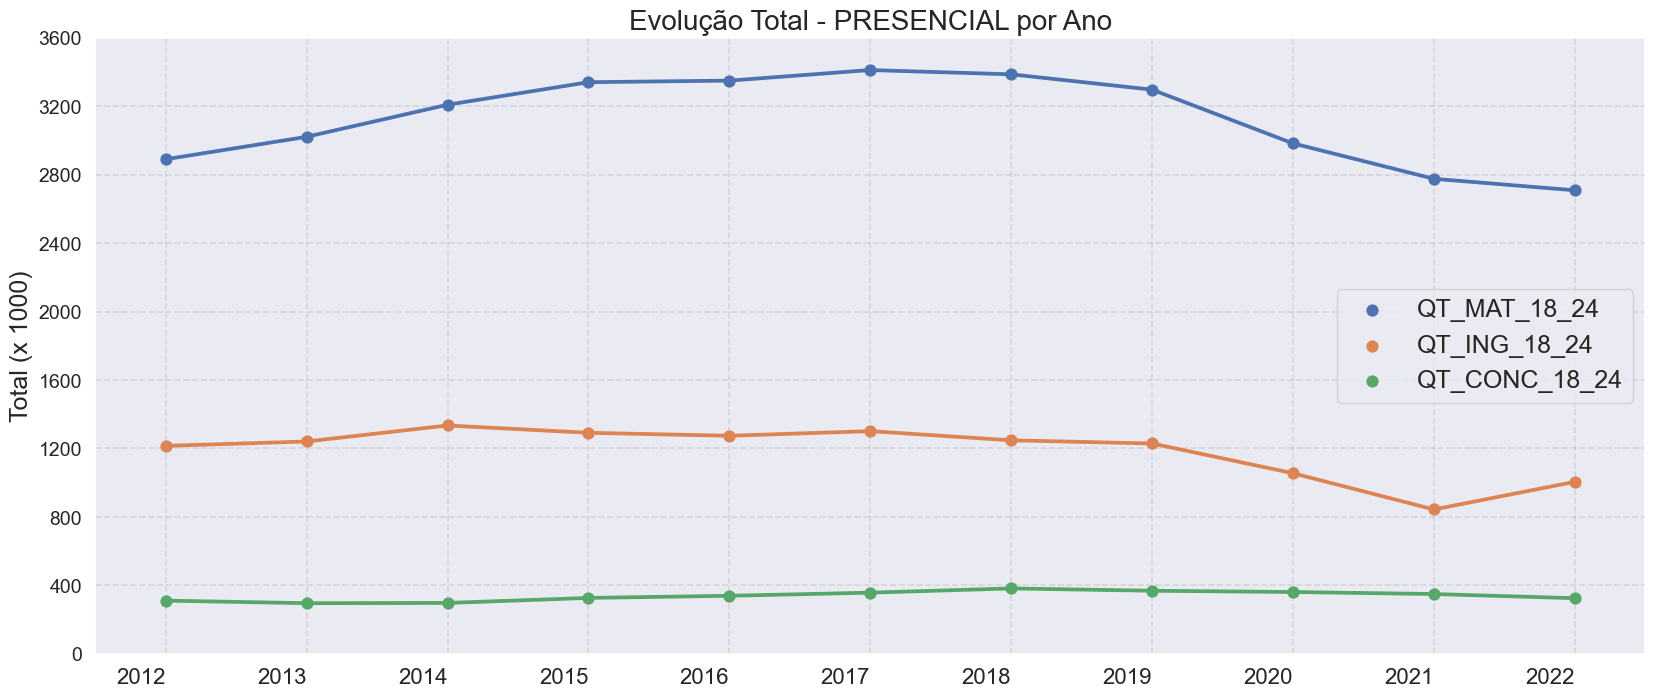

In [57]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Faixa_etaria'
col_soma = 'Total'
legenda_outside = 'N'

gerar_plot_evol_ano(serie_18_24, col_ano, col_grupo, col_soma, legenda_outside)

### 25 a 29 anos

In [58]:
df1 = serie_matr_faixas[serie_matr_faixas['Faixa_etaria']=='QT_MAT_25_29'].rename(columns={'Total_MAT':'Total'})
df2 = serie_ingr_faixas[serie_ingr_faixas['Faixa_etaria']=='QT_ING_25_29'].rename(columns={'Total_Ingress':'Total'})
df3 = serie_concl_faixas[serie_concl_faixas['Faixa_etaria']=='QT_CONC_25_29'].rename(columns={'Total_Concl':'Total'})
serie_25_29 = pd.concat([df1, df2, df3])

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO   Faixa_etaria      Total
0          2012  QT_CONC_25_29  219664.00
1          2012   QT_ING_25_29  344138.00
2          2012   QT_MAT_25_29 1068217.00
3          2013  QT_CONC_25_29  208968.00
4          2013   QT_ING_25_29  335126.00

Soma da coluna Total nos anos de 2012 a 2022: 17043789.0


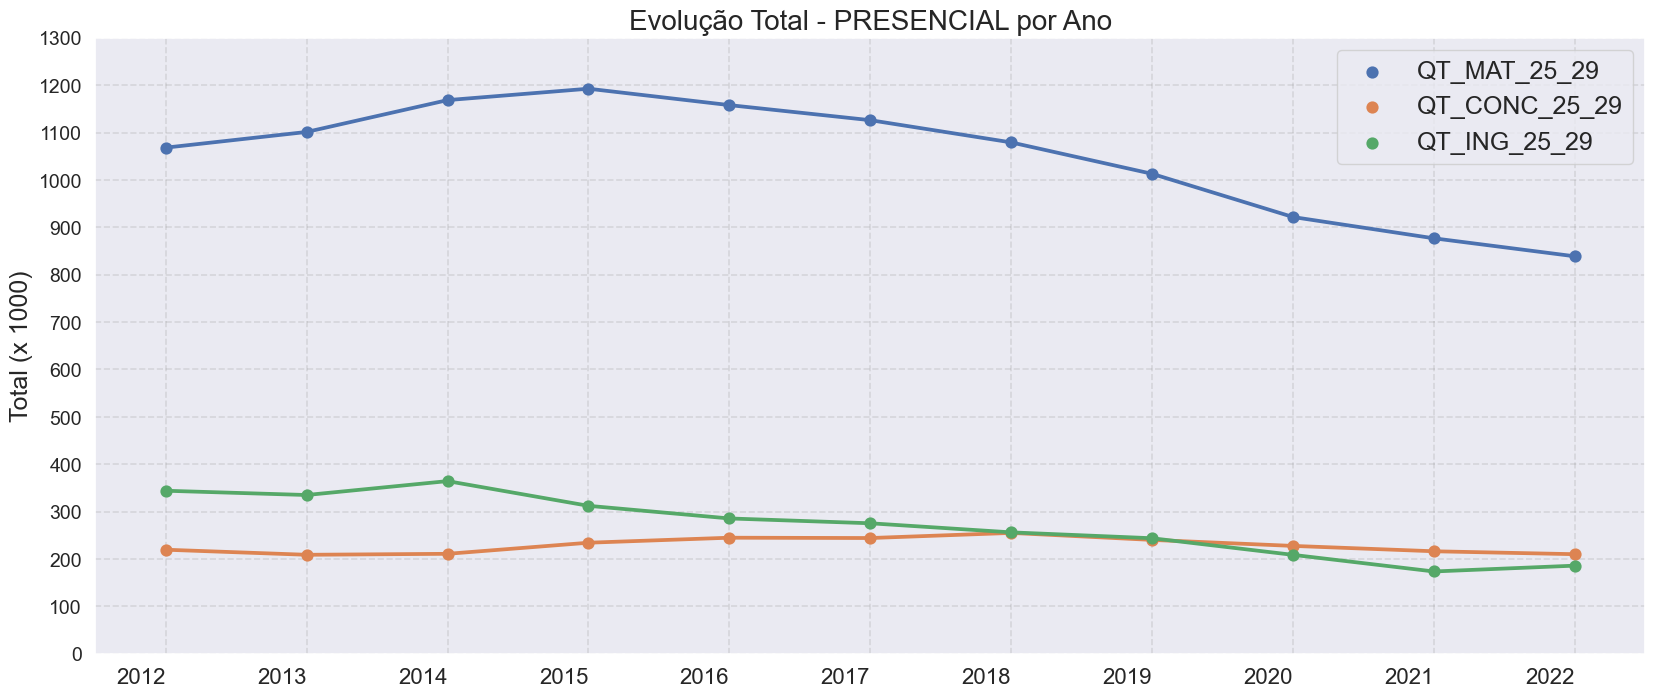

In [59]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Faixa_etaria'
col_soma = 'Total'
legenda_outside = 'N'

gerar_plot_evol_ano(serie_25_29, col_ano, col_grupo, col_soma, legenda_outside)

### 30 a 34 anos

In [60]:
df1 = serie_matr_faixas[serie_matr_faixas['Faixa_etaria']=='QT_MAT_30_34'].rename(columns={'Total_MAT':'Total'})
df2 = serie_ingr_faixas[serie_ingr_faixas['Faixa_etaria']=='QT_ING_30_34'].rename(columns={'Total_Ingress':'Total'})
df3 = serie_concl_faixas[serie_concl_faixas['Faixa_etaria']=='QT_CONC_30_34'].rename(columns={'Total_Concl':'Total'})
serie_30_34 = pd.concat([df1, df2, df3])

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO   Faixa_etaria     Total
0          2012  QT_CONC_30_34 110680.00
1          2012   QT_ING_30_34 199368.00
2          2012   QT_MAT_30_34 566482.00
3          2013  QT_CONC_30_34 103917.00
4          2013   QT_ING_30_34 197985.00

Soma da coluna Total nos anos de 2012 a 2022: 8549832.0


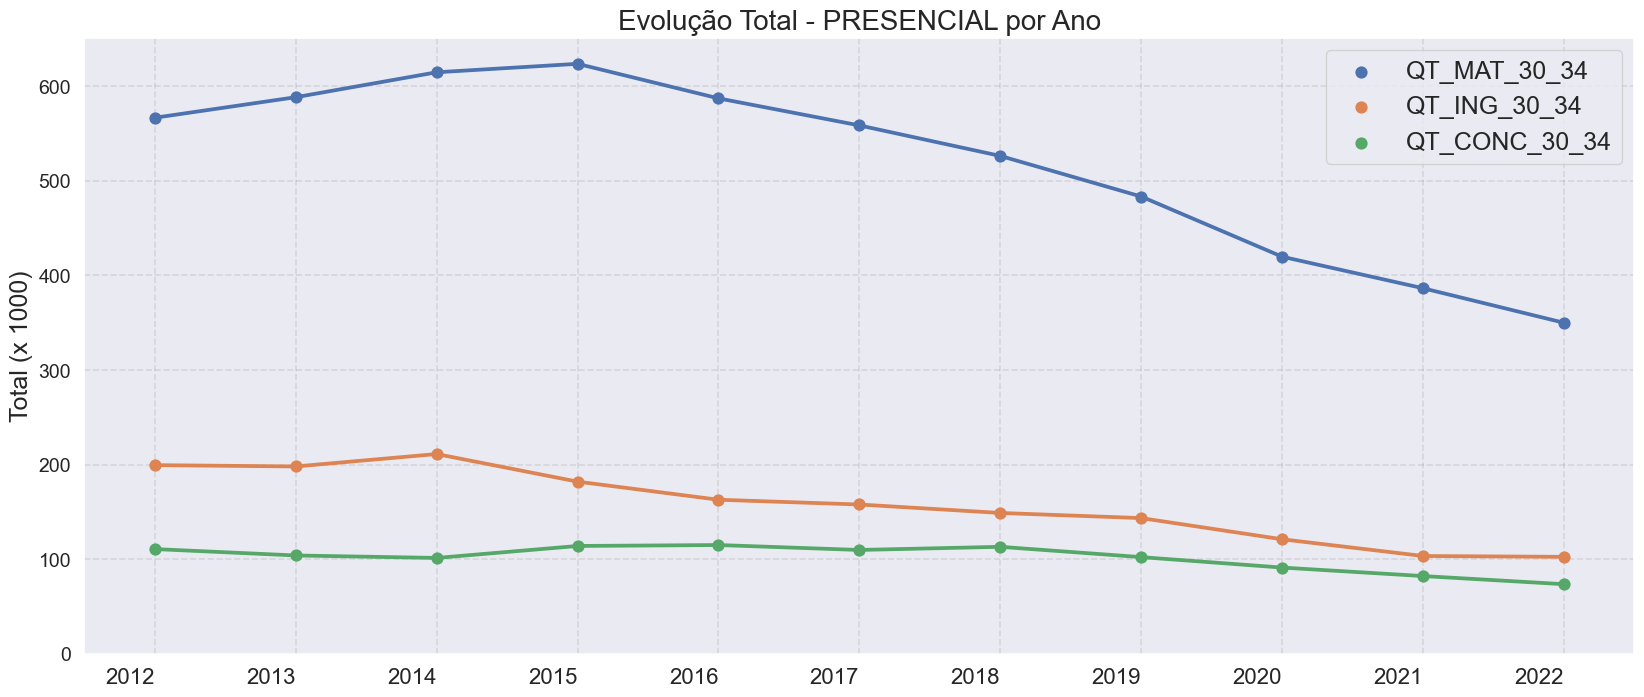

In [61]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Faixa_etaria'
col_soma = 'Total'
legenda_outside = 'N'

gerar_plot_evol_ano(serie_30_34, col_ano, col_grupo, col_soma, legenda_outside)

### 35 a 39 anos

In [62]:
df1 = serie_matr_faixas[serie_matr_faixas['Faixa_etaria']=='QT_MAT_35_39'].rename(columns={'Total_MAT':'Total'})
df2 = serie_ingr_faixas[serie_ingr_faixas['Faixa_etaria']=='QT_ING_35_39'].rename(columns={'Total_Ingress':'Total'})
df3 = serie_concl_faixas[serie_concl_faixas['Faixa_etaria']=='QT_CONC_35_39'].rename(columns={'Total_Concl':'Total'})
serie_35_39 = pd.concat([df1, df2, df3])

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO   Faixa_etaria     Total
0          2012  QT_CONC_35_39  57387.00
1          2012   QT_ING_35_39 102053.00
2          2012   QT_MAT_35_39 293387.00
3          2013  QT_CONC_35_39  55397.00
4          2013   QT_ING_35_39 105913.00

Soma da coluna Total nos anos de 2012 a 2022: 5054353.0


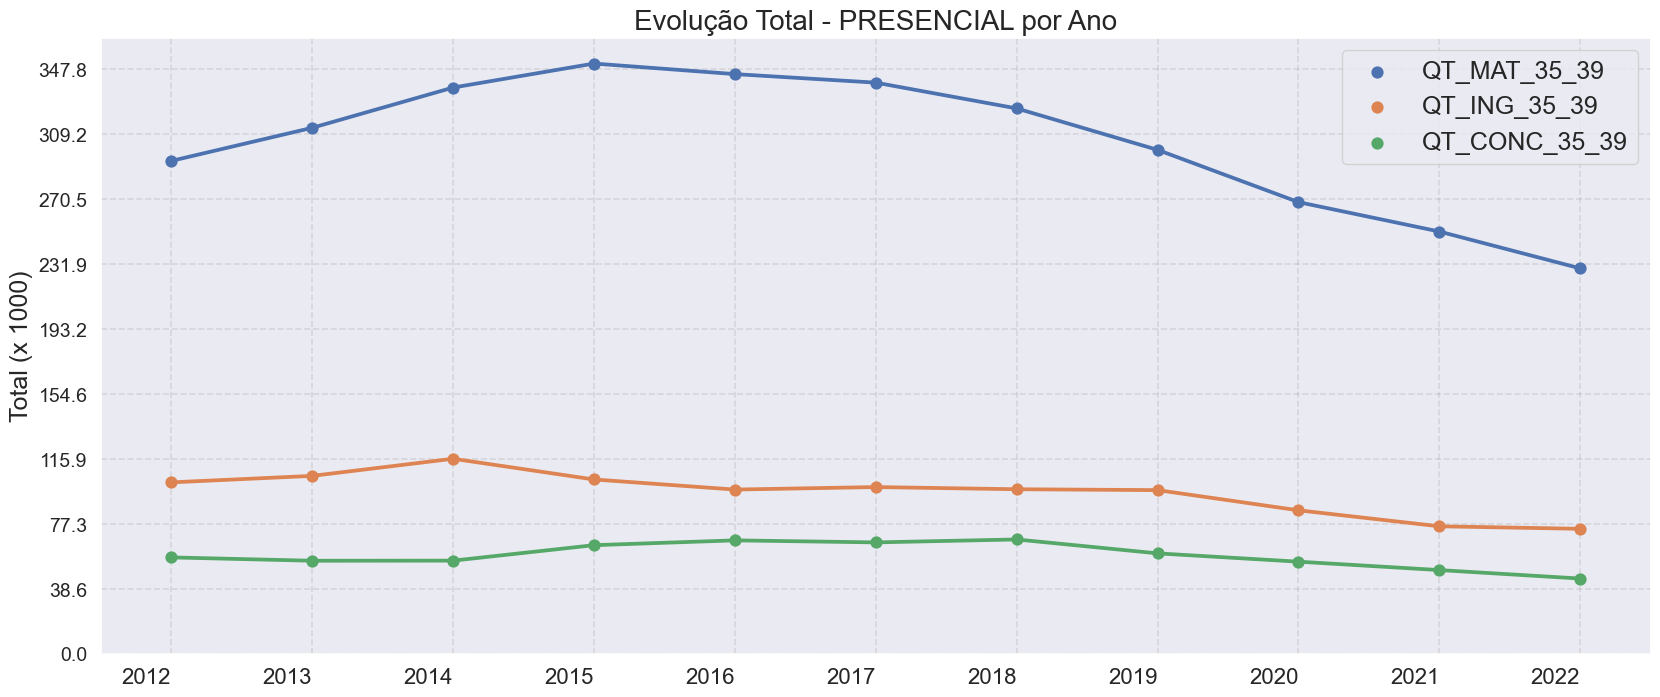

In [63]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Faixa_etaria'
col_soma = 'Total'
legenda_outside = 'N'

gerar_plot_evol_ano(serie_35_39, col_ano, col_grupo, col_soma, legenda_outside)

### Acima 40 anos

In [64]:
df1 = serie_matr_faixas[serie_matr_faixas['Faixa_etaria']=='QT_MAT_40_49'].rename(columns={'Total_MAT':'Total'})
df2 = serie_ingr_faixas[serie_ingr_faixas['Faixa_etaria']=='QT_ING_40_49'].rename(columns={'Total_Ingress':'Total'})
df3 = serie_concl_faixas[serie_concl_faixas['Faixa_etaria']=='QT_CONC_40_49'].rename(columns={'Total_Concl':'Total'})

df4 = serie_matr_faixas[serie_matr_faixas['Faixa_etaria']=='QT_MAT_50_59'].rename(columns={'Total_MAT':'Total'})
df5 = serie_ingr_faixas[serie_ingr_faixas['Faixa_etaria']=='QT_ING_50_59'].rename(columns={'Total_Ingress':'Total'})
df6 = serie_concl_faixas[serie_concl_faixas['Faixa_etaria']=='QT_CONC_50_59'].rename(columns={'Total_Concl':'Total'})

df7 = serie_matr_faixas[serie_matr_faixas['Faixa_etaria']=='QT_MAT_60_MAIS'].rename(columns={'Total_MAT':'Total'})
df8 = serie_ingr_faixas[serie_ingr_faixas['Faixa_etaria']=='QT_ING_60_MAIS'].rename(columns={'Total_Ingress':'Total'})
df9 = serie_concl_faixas[serie_concl_faixas['Faixa_etaria']=='QT_CONC_60_MAIS'].rename(columns={'Total_Concl':'Total'})
                                                                                              
serie_acima40 = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9])

serie_acima40['Faixa_etaria'] = np.where(serie_acima40['Faixa_etaria'].str.contains('QT_CONC'),'QT_CONC_acima_40',serie_acima40['Faixa_etaria'])
serie_acima40['Faixa_etaria'] = np.where(serie_acima40['Faixa_etaria'].str.contains('QT_ING'),'QT_ING_acima_40',serie_acima40['Faixa_etaria'])
serie_acima40['Faixa_etaria'] = np.where(serie_acima40['Faixa_etaria'].str.contains('QT_MAT'),'QT_MAT_acima_40',serie_acima40['Faixa_etaria'])

serie_acima40 = serie_acima40.groupby(['NU_ANO_CENSO','Faixa_etaria'])['Total'].sum().reset_index()
serie_acima40.head()

NU_ANO_CENSO      Faixa_etaria     Total
0          2012  QT_CONC_acima_40  71377.00
1          2012   QT_ING_acima_40 113421.00
2          2012   QT_MAT_acima_40 344095.00
3          2013  QT_CONC_acima_40  67346.00
4          2013   QT_ING_acima_40 115471.00

Exibindo alguns registros do df consolidado...



NU_ANO_CENSO      Faixa_etaria     Total
0          2012  QT_CONC_acima_40  71377.00
1          2012   QT_ING_acima_40 113421.00
2          2012   QT_MAT_acima_40 344095.00
3          2013  QT_CONC_acima_40  67346.00
4          2013   QT_ING_acima_40 115471.00

Soma da coluna Total nos anos de 2012 a 2022: 5925218.0


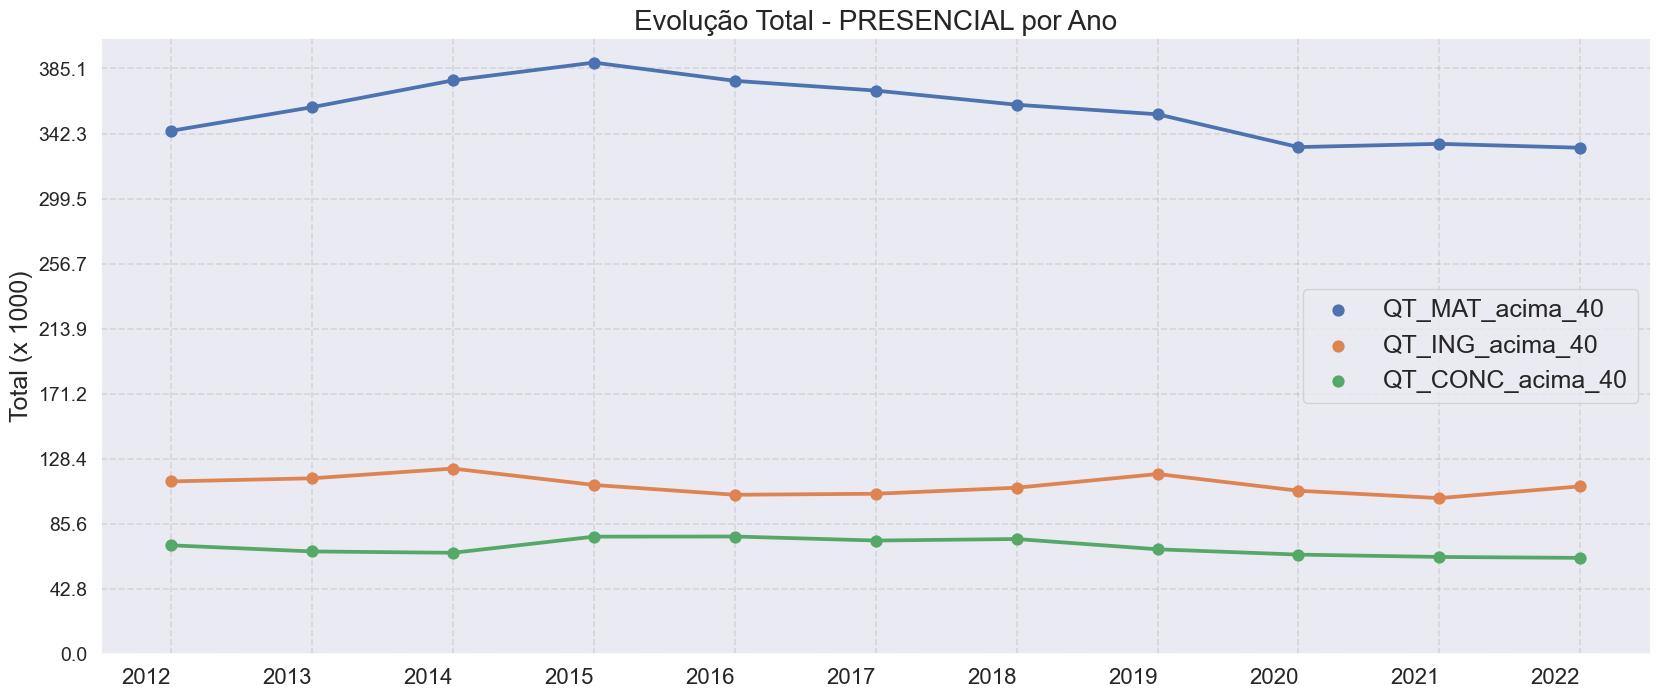

In [65]:
col_ano = 'NU_ANO_CENSO'
col_grupo = 'Faixa_etaria'
col_soma = 'Total'
legenda_outside = 'N'

gerar_plot_evol_ano(serie_acima40, col_ano, col_grupo, col_soma, legenda_outside)

## TreeMap - Total Cursos x Total Matrículas

In [66]:
#para checar
#df_all[df_all['NU_ANO_CENSO']==ano].groupby('NO_CINE_AREA_GERAL')['QT_MAT'].sum()
#df_all[df_all['NU_ANO_CENSO']==ano].groupby('NO_CINE_AREA_GERAL')['QT_CURSO'].sum()
#df_all[df_all['NU_ANO_CENSO']==ano].groupby('NO_CINE_AREA_GERAL')['QT_ING'].sum()

#para um ano específico
# ano = 2022
# distr_cursos = df_all[df_all['NU_ANO_CENSO']==ano].groupby('NO_CINE_AREA_GERAL').\
#                                         agg({'QT_CURSO':'sum',
#                                              'QT_MAT':'sum',                                             
#                                              'QT_ING':'sum',
#                                              'QT_CONC':'sum'
#                                              }).reset_index()

Treemap de Cursos e Matriculas para o ano de 2012:


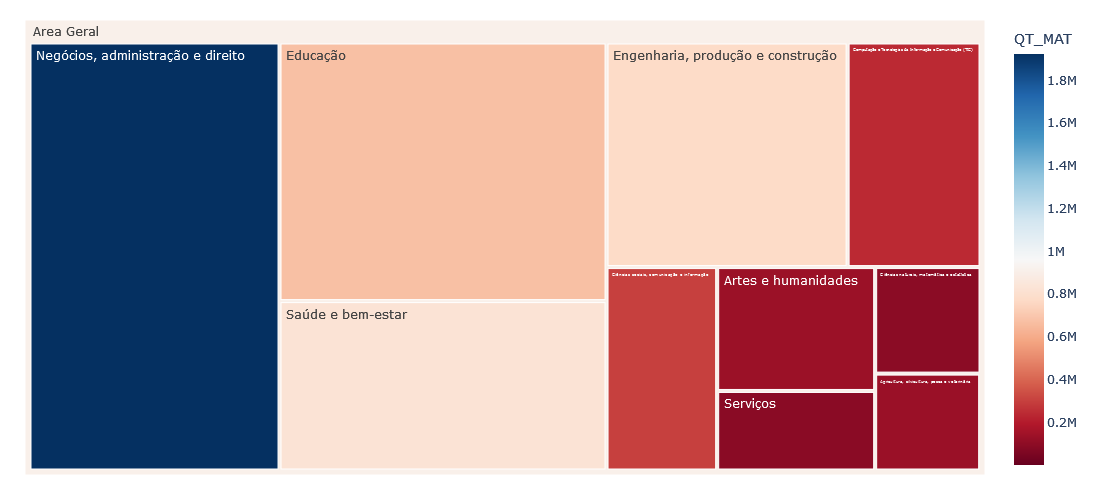

Treemap de Cursos e Matriculas para o ano de 2013:


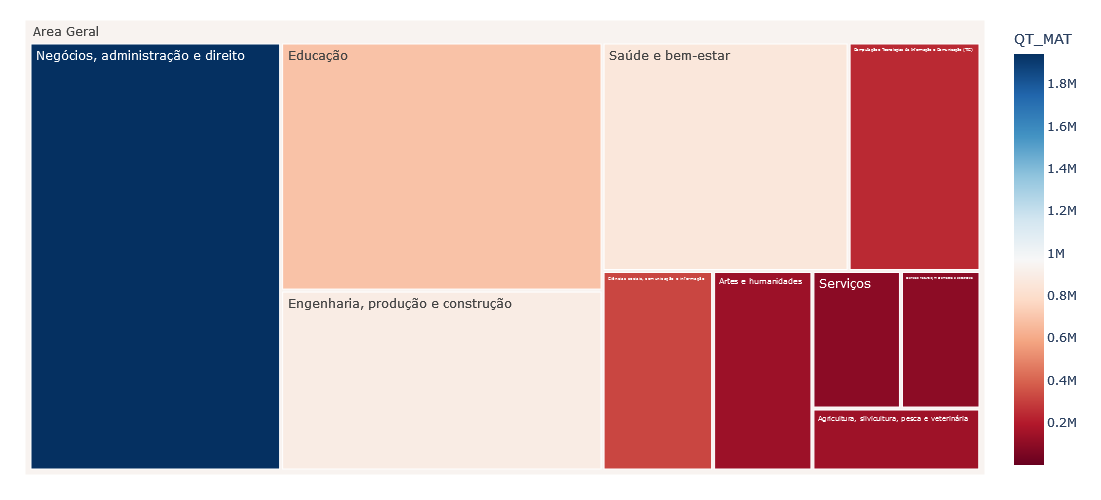

Treemap de Cursos e Matriculas para o ano de 2014:


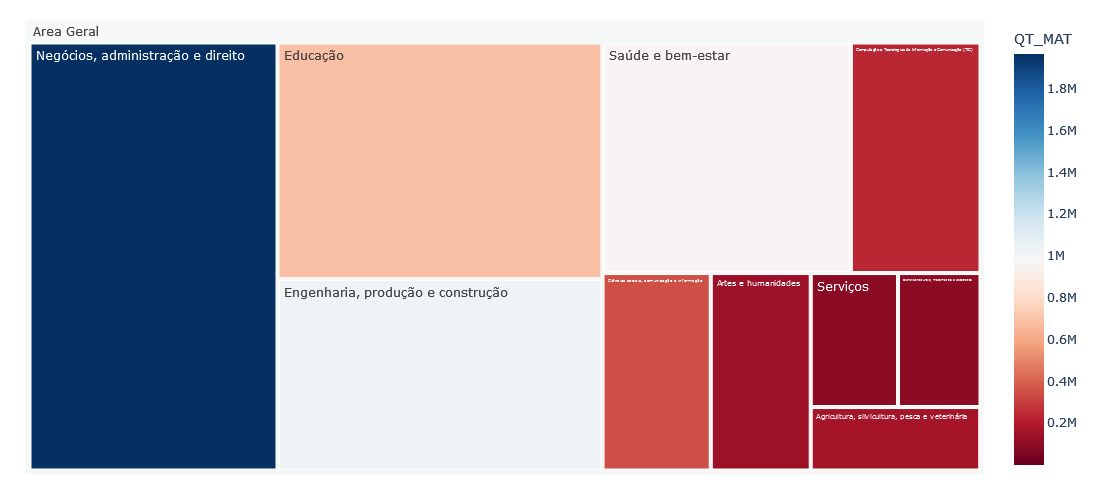

Treemap de Cursos e Matriculas para o ano de 2015:


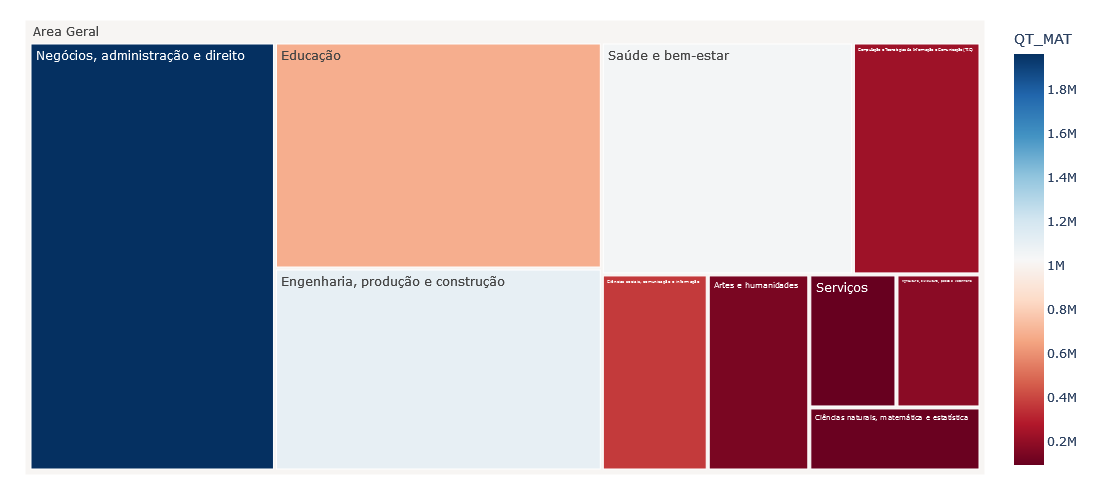

Treemap de Cursos e Matriculas para o ano de 2016:


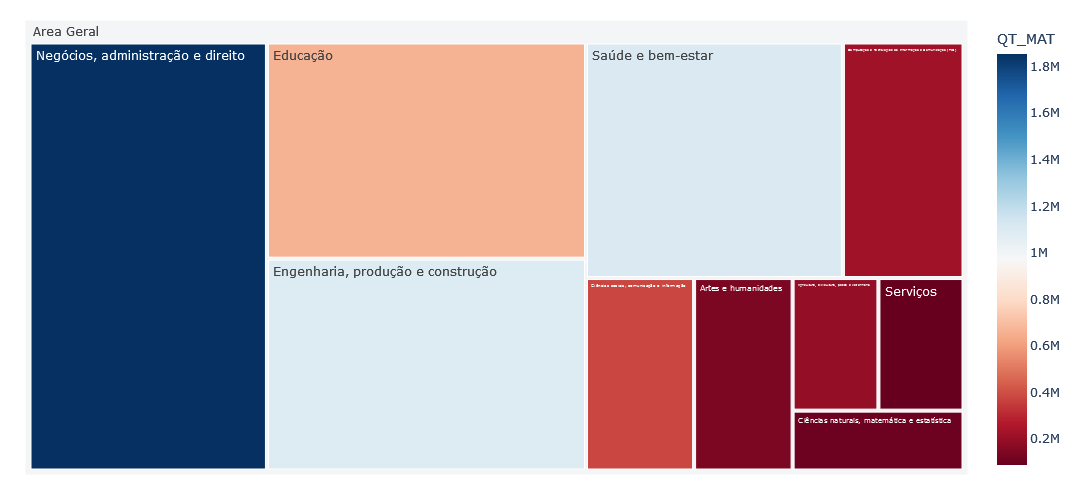

Treemap de Cursos e Matriculas para o ano de 2017:


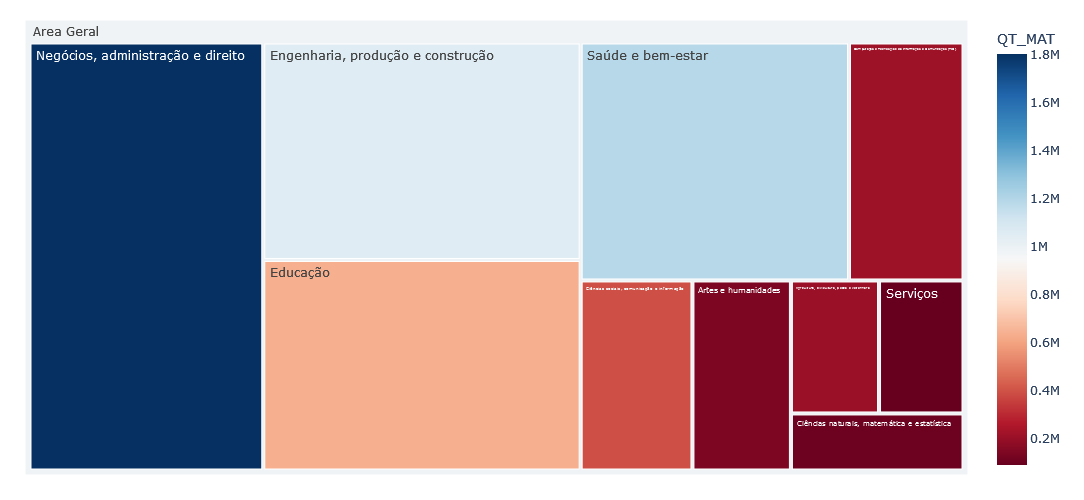

Treemap de Cursos e Matriculas para o ano de 2018:


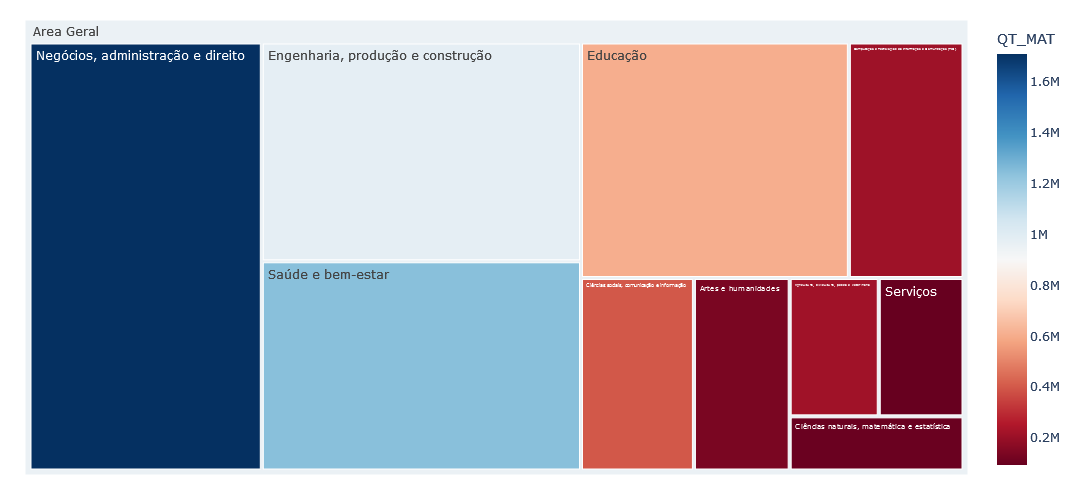

Treemap de Cursos e Matriculas para o ano de 2019:


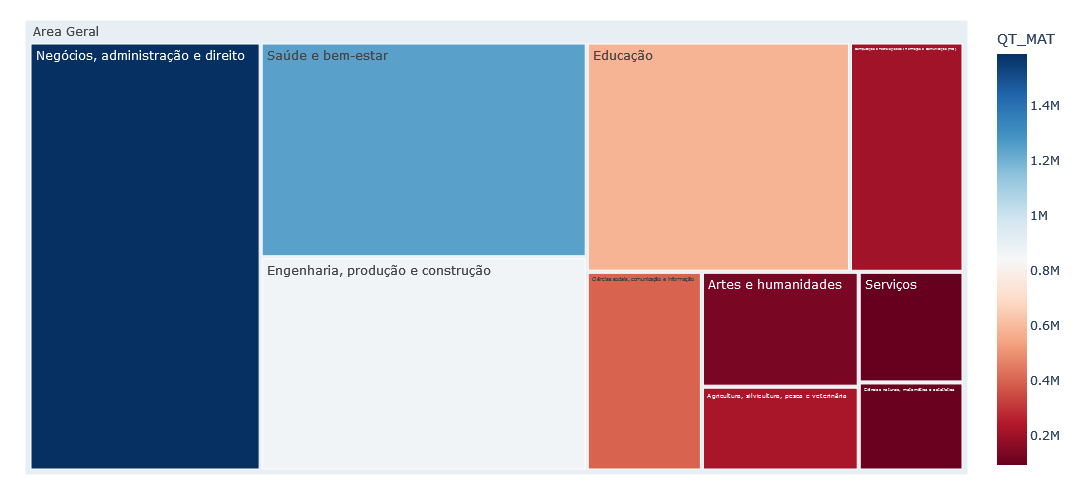

Treemap de Cursos e Matriculas para o ano de 2020:


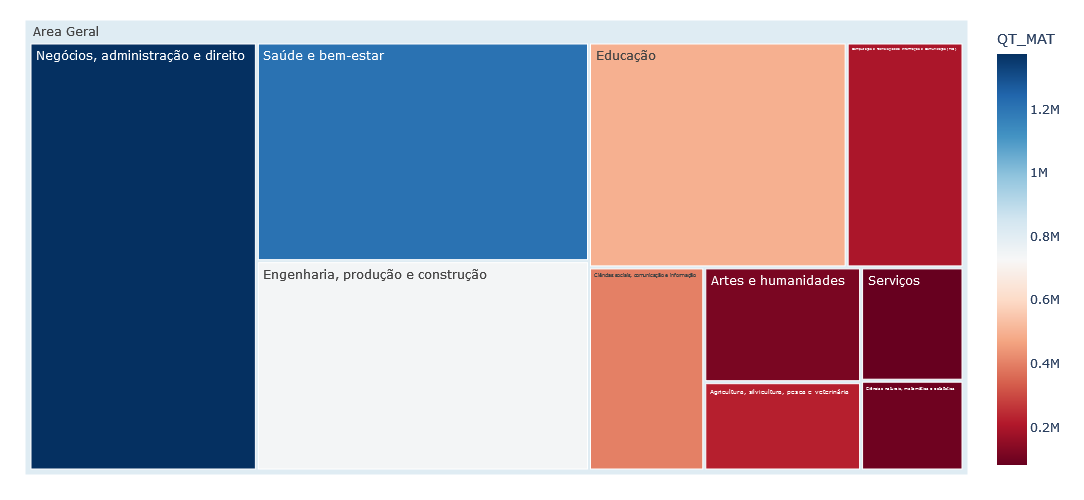

Treemap de Cursos e Matriculas para o ano de 2021:


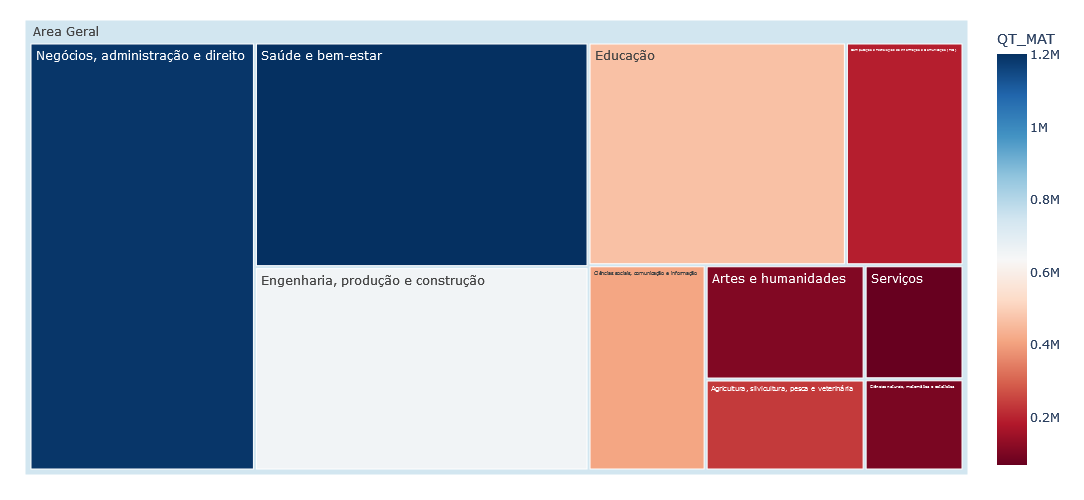

Treemap de Cursos e Matriculas para o ano de 2022:


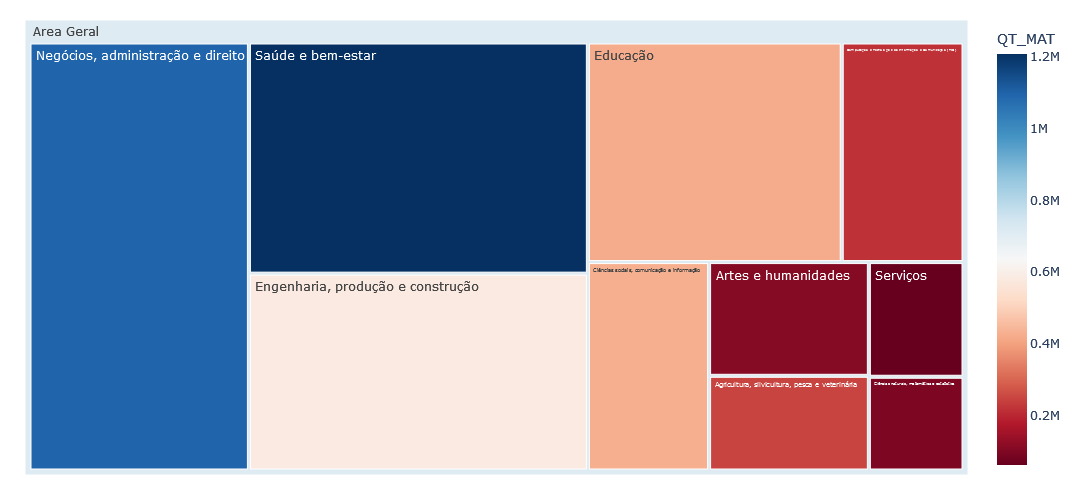

In [67]:
# para todos os anos
distr_cursos = df_all.groupby(['NU_ANO_CENSO','NO_CINE_AREA_GERAL']).\
                                        agg({'QT_CURSO':'sum',
                                             'QT_MAT':'sum',                                             
                                             'QT_ING':'sum',
                                             'QT_CONC':'sum'
                                             }).reset_index()
l_anos = range(2012,2023,1)

for ano in l_anos:
    print(f'Treemap de Cursos e Matriculas para o ano de {ano}:')
    fig = px.treemap(distr_cursos[distr_cursos['NU_ANO_CENSO']==ano], 
                 path = [px.Constant('Area Geral'), 'NO_CINE_AREA_GERAL'], 
                 values = 'QT_CURSO', 
                 color_continuous_scale='RdBu',
                 color = 'QT_MAT', width=1000, height=500)
    fig.update_layout(margin = dict(t=20, l=25, r=25, b=25))
    fig.show()